# Exploratory Data Analysis of Chest X-ray dataset

In this notebook we we do an EDA of a dataset of chest x-rays from the NIH (National Institutes of Health) dataset which can also be found in this [kaggle competition](https://www.kaggle.com/nih-chest-xrays/data). Note this is a very large dataset of images (42 GB).

The NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)

We will be using this dataset later specifically for building a model for detecting Pneumonia. This EDA should help us understand how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

## Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import matplotlib.image as mpimg
import copy

## Approach

I intend to look at the following in this EDA:

* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: We will use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

In [2]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
1179   00000289_005.png     No Finding            5         289           68   
17511  00004724_008.png     No Finding            8        4724           50   
94719  00024454_000.png         Nodule            0       24454           40   

      Patient Gender View Position  OriginalImage[Width  Height]  \
1179               F            PA                 2992     2991   
17511              M            AP                 2500     2048   
94719              F            PA                 2662     2991   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  
1179                         0.143  0.143          NaN  
17511                        0.171  0.171          NaN  
94719                        0.143  0.143          NaN

In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
1430  00007428_006.png     No Finding            6        7428        059Y   
964   00005026_000.png     No Finding            0        5026        037Y   
1575  00008177_000.png     No Finding            0        8177        037Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
1430              M            PA                2500                 2048   
964               M            PA                2500                 2048   
1575              M            PA                2992                 2991   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
1430                        0.168                        0.168  
964                         0.171                        0.171  
1575                        0.143                        0.143

## 1. Data Wrangling

We will first clean & re-structure the data to make it easier to do our analysis on.

### 1.1 Data cleaning

Lets first look at the data values & distributions to see if they are good.

In [4]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


So we have no missing values for any columns. Lets look at the range of values for the numeric columns.

In [5]:
all_xray_df.describe()

Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112120.000000  112120.000000  112120.000000        112120.000000   
mean        8.573751   14346.381743      46.901463          2646.078844   
std        15.406320    8403.876972      16.839923           341.246429   
min         0.000000       1.000000       1.000000          1143.000000   
25%         0.000000    7310.750000      35.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000     414.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  Unnamed: 11  
count  112120.000000                112120.000000  112120.000000          0.0  
mean     2486.438842                     0.155649       0.155649          NaN  
std       401.268227                     0.016174       0.016174          NaN  
min       966.000000                     0.115000       0.115000          NaN  
25%      2048.000000                     0.143000       0.143000          NaN  
50%      2544.000000                     0.143000       0.143000          NaN  
75%      2991.000000                     0.168000       0.168000          NaN  
max      4715.000000                     0.198800       0.198800          NaN

Ok so we have some odd ages here with a max of 414! Given the oldest person who ever lived was 122, lets drop all rows with ages less than 120.

In [6]:
all_xray_df = all_xray_df[all_xray_df['Patient Age'] < 120]
all_xray_df.describe()

Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112104.000000  112104.000000  112104.000000        112104.000000   
mean        8.574172   14345.720724      46.872574          2646.035253   
std        15.406734    8403.980520      16.598152           341.243771   
min         0.000000       1.000000       1.000000          1143.000000   
25%         0.000000    7308.000000      35.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000      95.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  Unnamed: 11  
count  112104.000000                112104.000000  112104.000000          0.0  
mean     2486.393153                     0.155651       0.155651          NaN  
std       401.270806                     0.016174       0.016174          NaN  
min       966.000000                     0.115000       0.115000          NaN  
25%      2048.000000                     0.143000       0.143000          NaN  
50%      2544.000000                     0.143000       0.143000          NaN  
75%      2991.000000                     0.168000       0.168000          NaN  
max      4715.000000                     0.198800       0.198800          NaN

In [7]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


### 1.2 Data re-structuring

Let make various changes to make our data easier to do our analysis on.

In [8]:
## We will read all the full image filepaths into a sample dataframe for easier manipulation
## NOTE: Our sample df will only be used to look at pixel-level asssesments
data_sample_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path'] = sample_df['Image Index'].map(data_sample_paths.get)
sample_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
3138  00015449_002.png     No Finding            2       15449        039Y   
681   00003520_002.png     No Finding            2        3520        085Y   
816   00004328_003.png         Nodule            3        4328        059Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
3138              F            PA                2992                 2693   
681               M            PA                2992                 2991   
816               M            PA                2048                 2500   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  \
3138                        0.143                        0.143   
681                         0.143                        0.143   
816                         0.171                        0.171   

                                          path  
3138  /data/images_007/images/00015449_002.png  
681   /data/images_002/images/00003520_002.png  
816   /data/images_003/images/00004328_003.png

In [9]:
# Re-format multi-label column into separate columns for each label one-hot encoded - sample dataset
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # ignore empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
1976  00010346_001.png     No Finding            1       10346        049Y   
4010  00019769_003.png     No Finding            3       19769        048Y   
941   00004898_004.png     No Finding            4        4898        051Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
1976              M            AP                2500                 2048   
4010              F            PA                2544                 3048   
941               M            AP                2500                 2048   

      OriginalImagePixelSpacing_x  ...  Emphysema Fibrosis  Hernia  \
1976                        0.168  ...        0.0      0.0     0.0   
4010                        0.139  ...        0.0      0.0     0.0   
941                         0.171  ...        0.0      0.0     0.0   

      Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
1976           0.0   0.0         1.0     0.0                 0.0        0.0   
4010           0.0   0.0         1.0     0.0                 0.0        0.0   
941            0.0   0.0         1.0     0.0                 0.0        0.0   

      Pneumothorax  
1976           0.0  
4010           0.0  
941            0.0  

[3 rows x 27 columns]

In [10]:
# Re-format multi-label column into separate columns for each label one-hot encoded - main dataset
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # ignore empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
41129  00010653_001.png    Atelectasis            1       10653           50   
85807  00021175_000.png    Atelectasis            0       21175           62   
16092  00004299_004.png     No Finding            4        4299           81   

      Patient Gender View Position  OriginalImage[Width  Height]  \
41129              F            PA                 2854     2581   
85807              M            PA                 2674     2533   
16092              M            AP                 2500     2048   

       OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  Hernia  \
41129                        0.143  ...        0.0       0.0     0.0   
85807                        0.143  ...        0.0       0.0     0.0   
16092                        0.171  ...        0.0       0.0     0.0   

       Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
41129           0.0   0.0         0.0     0.0                 0.0        0.0   
85807           0.0   0.0         0.0     0.0                 0.0        0.0   
16092           0.0   0.0         1.0     0.0                 0.0        0.0   

       Pneumothorax  
41129           0.0  
85807           0.0  
16092           0.0  

[3 rows x 27 columns]

## 2 Exploratory data analysis

### 2.1 Univariate analysis of key fields for patient demographic data

In [11]:
# Plot key stats for numerical fields
all_xray_df.describe()

Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112104.000000  112104.000000  112104.000000        112104.000000   
mean        8.574172   14345.720724      46.872574          2646.035253   
std        15.406734    8403.980520      16.598152           341.243771   
min         0.000000       1.000000       1.000000          1143.000000   
25%         0.000000    7308.000000      35.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000      95.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  Unnamed: 11  \
count  112104.000000                112104.000000  112104.000000          0.0   
mean     2486.393153                     0.155651       0.155651          NaN   
std       401.270806                     0.016174       0.016174          NaN   
min       966.000000                     0.115000       0.115000          NaN   
25%      2048.000000                     0.143000       0.143000          NaN   
50%      2544.000000                     0.143000       0.143000          NaN   
75%      2991.000000                     0.168000       0.168000          NaN   
max      4715.000000                     0.198800       0.198800          NaN   

         Atelectasis   Cardiomegaly  ...      Emphysema       Fibrosis  \
count  112104.000000  112104.000000  ...  112104.000000  112104.000000   
mean        0.103101       0.024763  ...       0.022443       0.015040   
std         0.304092       0.155402  ...       0.148121       0.121711   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...       0.000000       0.000000   
50%         0.000000       0.000000  ...       0.000000       0.000000   
75%         0.000000       0.000000  ...       0.000000       0.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

              Hernia   Infiltration           Mass     No Finding  \
count  112104.000000  112104.000000  112104.000000  112104.000000   
mean        0.002025       0.177433       0.051550       0.538366   
std         0.044954       0.382037       0.221118       0.498528   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         0.000000       0.000000       0.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

              Nodule  Pleural_Thickening      Pneumonia   Pneumothorax  
count  112104.000000       112104.000000  112104.000000  112104.000000  
mean        0.056474            0.030186       0.012756       0.047286  
std         0.230836            0.171100       0.112220       0.212252  
min         0.000000            0.000000       0.000000       0.000000  
25%         0.000000            0.000000       0.000000       0.000000  
50%         0.000000            0.000000       0.000000       0.000000  
75%         0.000000            0.000000       0.000000       0.000000  
max         1.000000            1.000000       1.000000       1.000000  

[8 rows x 23 columns]

(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

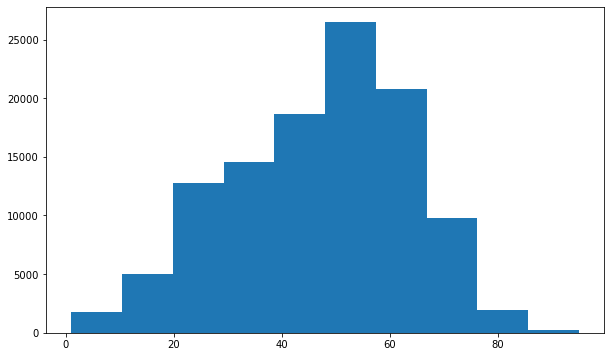

In [12]:
## Explore distribution of ages
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'])

So we can see the center of this distribution is roughly around 50, and indeed the key stats above confirm the median age is 49 and the mean age is 46.

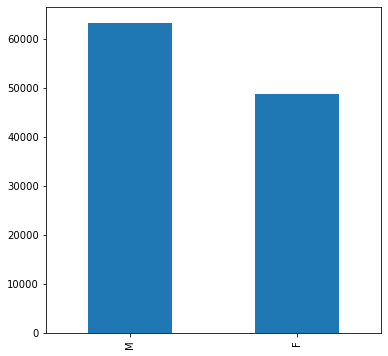

In [13]:
## Explore gender
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

This shows us that in the general dataset, there are more males than females my a small margin.

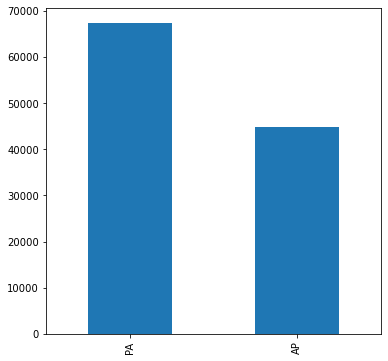

In [14]:
## Explore view position
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')

Here we can see that there are more observations of the PA view position than the AP one.

In [15]:
## Explore labels - total of dataset for each label
all_xray_df[all_labels].sum()

Atelectasis           11558.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2302.0
Effusion              13316.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19891.0
Mass                   5779.0
No Finding            60353.0
Nodule                 6331.0
Pleural_Thickening     3384.0
Pneumonia              1430.0
Pneumothorax           5301.0
dtype: float64

In [16]:
len(all_xray_df)

112104

In [17]:
## Explore labels - percentage of dataset for each label
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103101
Cardiomegaly          0.024763
Consolidation         0.041631
Edema                 0.020535
Effusion              0.118783
Emphysema             0.022443
Fibrosis              0.015040
Hernia                0.002025
Infiltration          0.177433
Mass                  0.051550
No Finding            0.538366
Nodule                0.056474
Pleural_Thickening    0.030186
Pneumonia             0.012756
Pneumothorax          0.047286
dtype: float64

In [18]:
# Number of diseases per patient (mean)
all_xray_df[all_labels].mean().sort_values(ascending=False)

No Finding            0.538366
Infiltration          0.177433
Effusion              0.118783
Atelectasis           0.103101
Nodule                0.056474
Mass                  0.051550
Pneumothorax          0.047286
Consolidation         0.041631
Pleural_Thickening    0.030186
Cardiomegaly          0.024763
Emphysema             0.022443
Edema                 0.020535
Fibrosis              0.015040
Pneumonia             0.012756
Hernia                0.002025
dtype: float64

Here we can see that just over half the observations have 'No finding', while the dataset allows for multiple labels per sample, we know that No finding only occurs with no other labels - therefore we can say that just over half of the observations in the general dataset have no observations of any disease. 

Conversely, we can say that just under half of the datset do have observations have at least one label of disease.

We can also see that our key label of interest to predict 'Pneumonia' only occurs in 1% of the observations.

Some key stats for labels:

- Total cases: 112104
- Total disease cases: 51751
- Total no disease cases: 60353
- Total with Pneumonia cases: 1430
- Total Non-Pneumonia cases with another disease: 58923
- Pneumonia cases: 1.2%
- Non-Pneumonia cases: 98.8%

Looking at the mean number of disease per patient, excluding 'No Finding' the top 5 most commen diseases accross all patients with their means are:

- Infiltration: 0.177433
- Effusion: 0.118783
- Atelectasis: 0.103101
- Nodule: 0.056474
- Mass: 0.051550

In fact with respect to our disease of interest Pneumonia, Pneumonia is actually the second rarest disease at all in the dataset, second only to Hernia.

[Text(0, 0.5, 'Number of Images with Label')]

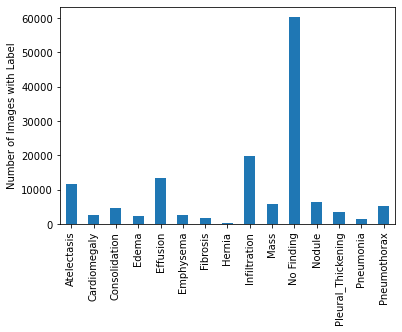

In [19]:
# Explore labels - plot proportion of dataset for each label
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

### 2.2 Comparison of key fields for metadata as a whole to those of Pneumonia cases

In [20]:
# Select rows with Pneumonia cases
pneumonia_df = all_xray_df[all_xray_df['Pneumonia'] == 1]
pneumonia_df.head()

Image Index                                     Finding Labels  \
48   00000013_010.png                    Effusion|Pneumonia|Pneumothorax   
126  00000032_012.png          Atelectasis|Consolidation|Edema|Pneumonia   
253  00000056_000.png                                   Nodule|Pneumonia   
276  00000061_012.png  Edema|Effusion|Infiltration|Pleural_Thickening...   
279  00000061_015.png                                          Pneumonia   

     Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
48            10          13           60              M            AP   
126           12          32           55              F            AP   
253            0          56           76              M            PA   
276           12          61           77              M            AP   
279           15          61           77              M            AP   

     OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
48                  3056     2544                        0.139  ...   
126                 2500     2048                        0.168  ...   
253                 2500     2048                        0.168  ...   
276                 3056     2544                        0.139  ...   
279                 3056     2544                        0.139  ...   

     Emphysema  Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
48         0.0       0.0     0.0           0.0   0.0         0.0     0.0   
126        0.0       0.0     0.0           0.0   0.0         0.0     0.0   
253        0.0       0.0     0.0           0.0   0.0         0.0     1.0   
276        0.0       0.0     0.0           1.0   0.0         0.0     0.0   
279        0.0       0.0     0.0           0.0   0.0         0.0     0.0   

     Pleural_Thickening  Pneumonia  Pneumothorax  
48                  0.0        1.0           1.0  
126                 0.0        1.0           0.0  
253                 0.0        1.0           0.0  
276                 1.0        1.0           0.0  
279                 0.0        1.0           0.0  

[5 rows x 27 columns]

Text(0, 0.5, 'Number of x-ray observations')

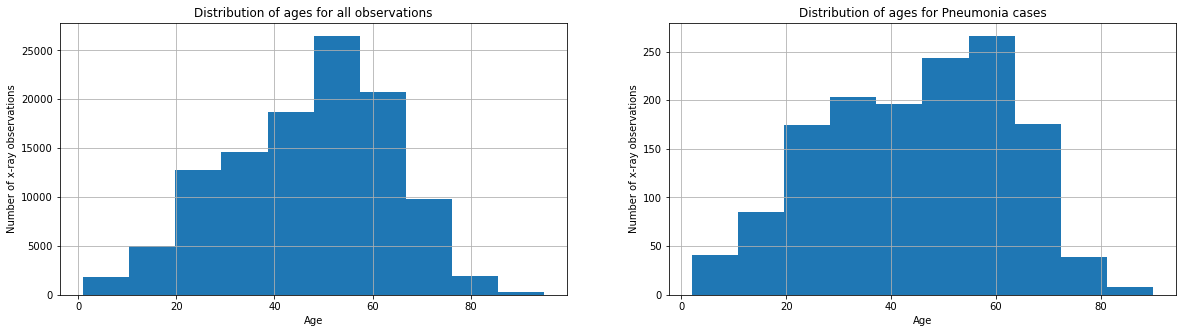

In [21]:
# Compare age distributions of all observations vs Pneumonia cases
fig, axes = plt.subplots(1, 2)
all_xray_df['Patient Age'].hist(ax=axes[0],figsize=(20,5))
pneumonia_df['Patient Age'].hist(ax=axes[1],figsize=(20,5))
axes[0].set_title('Distribution of ages for all observations')
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Number of x-ray observations")
axes[1].set_title('Distribution of ages for Pneumonia cases')
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Number of x-ray observations")

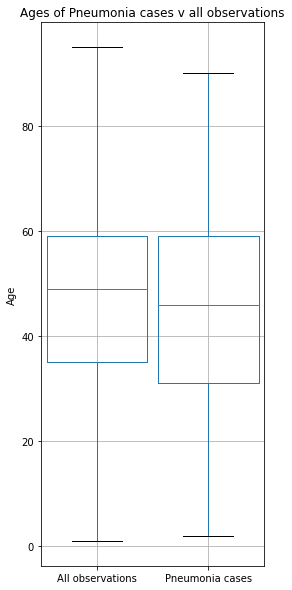

In [22]:
age_compare = pd.DataFrame()
age_compare['All observations'] = all_xray_df['Patient Age']
age_compare['Pneumonia cases'] = pneumonia_df['Patient Age']
age_compare.boxplot(figsize=(4,10), grid=True, widths=0.9)
plt.title('Ages of Pneumonia cases v all observations')
plt.ylabel('Age')
plt.show()

So we could summerise our observations here to say that while the Pneumonia cases have a very similar distribution of ages to all observations, the Pneumonia cases do seem to have more people in the age ranges of 20-40. Pneumonia cases also have a slightly lower maximum value compared to the main distribution.

In other words, while Pneumonia cases have a similar distribution in age range to the general population, Pneumonia is more likely to impact more a slightly narrower and slightly younger age range compared to the general population.

Lets now compare gender of all observations vs Pneumonia cases

Text(0, 0.5, 'Number of x-ray observations')

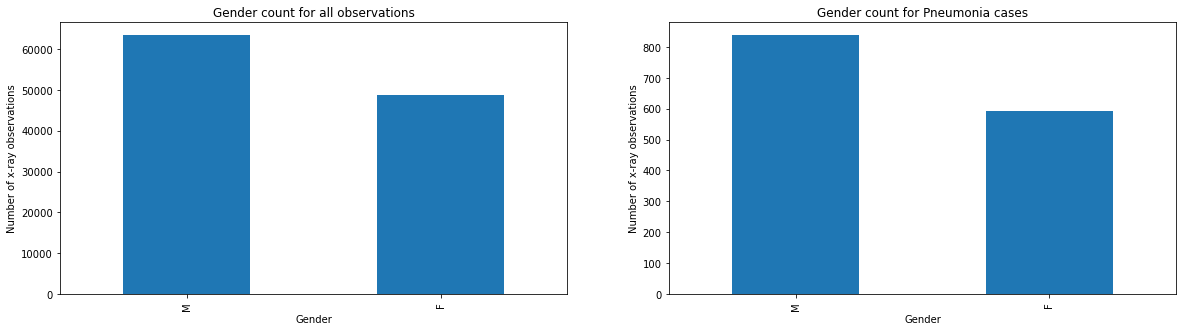

In [23]:
# Compare gender between all observations vs Pneumonia cases
fig, axes = plt.subplots(1, 2)
all_xray_df['Patient Gender'].value_counts().plot(ax=axes[0],kind='bar',figsize=(20,5))
pneumonia_df['Patient Gender'].value_counts().plot(ax=axes[1],kind='bar',figsize=(20,5))
axes[0].set_title('Gender count for all observations')
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Number of x-ray observations")
axes[1].set_title('Gender count for Pneumonia cases')
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Number of x-ray observations")

So while we can see that the proportions for males & females there are small differences in the general population vs Pneumonia cases, overall there is a similar proportion of males to females in both groups i.e. more males than females.

Lets explore view position accross the two groups.

Text(0, 0.5, 'Number of x-ray observations')

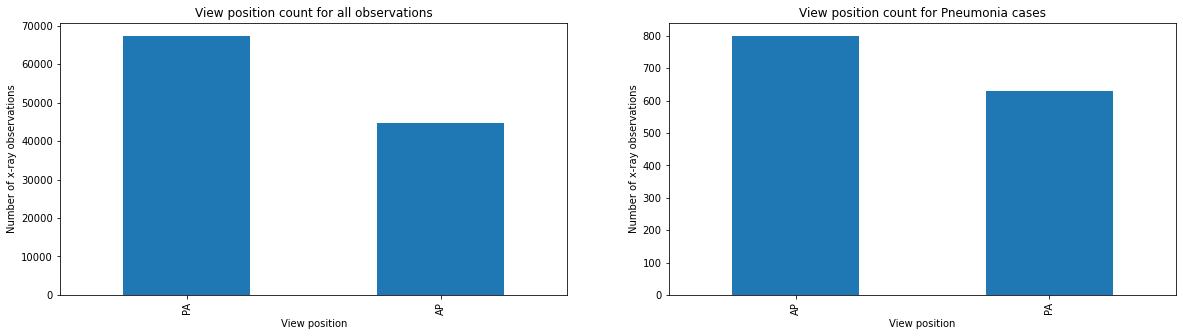

In [24]:
# Compare view position between all observations vs Pneumonia cases
fig, axes = plt.subplots(1, 2)
all_xray_df['View Position'].value_counts().plot(ax=axes[0],kind='bar',figsize=(20,5))
pneumonia_df['View Position'].value_counts().plot(ax=axes[1],kind='bar',figsize=(20,5))
axes[0].set_title('View position count for all observations')
axes[0].set_xlabel("View position")
axes[0].set_ylabel("Number of x-ray observations")
axes[1].set_title('View position count for Pneumonia cases')
axes[1].set_xlabel("View position")
axes[1].set_ylabel("Number of x-ray observations")

So here we can observe a significant difference in the view position. In the general observations there are usually more PA views than AP views, but in Pneumonia cases the reverse is true, there are usually more AP views than PA views.

Lets now look at the distribution of other diseases with respect to Pneumonia.

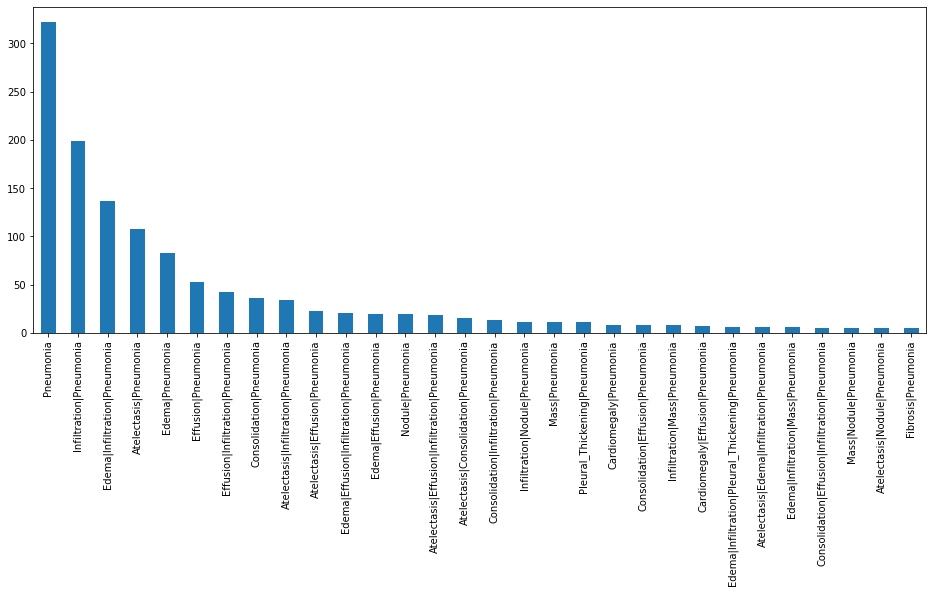

In [25]:
# The distribution of other diseases with respect to Pneumonia
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

In [26]:
# Show top 30 combinations
pneumonia_combinations = all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30]
print(pneumonia_combinations)
print(pneumonia_combinations.sum())

Pneumonia                                          322
Infiltration|Pneumonia                             199
Edema|Infiltration|Pneumonia                       137
Atelectasis|Pneumonia                              108
Edema|Pneumonia                                     83
Effusion|Pneumonia                                  53
Effusion|Infiltration|Pneumonia                     42
Consolidation|Pneumonia                             36
Atelectasis|Infiltration|Pneumonia                  34
Atelectasis|Effusion|Pneumonia                      23
Edema|Effusion|Infiltration|Pneumonia               21
Edema|Effusion|Pneumonia                            19
Nodule|Pneumonia                                    19
Atelectasis|Effusion|Infiltration|Pneumonia         18
Atelectasis|Consolidation|Pneumonia                 15
Consolidation|Infiltration|Pneumonia                13
Infiltration|Nodule|Pneumonia                       11
Mass|Pneumonia                                      11
Pleural_Th

So the top 5 diseases most commonly occuring with Pneumonia are:

- Infiltration
- Edema
- Atelectasis
- Effusion
- Consolidation

We can also see that the percentages of the top 5 disease combinations involving Pneumonia out of the top 30 are:

- Pneumonia: 25%
- Infiltration|Pneumonia: 16%
- Edema|Infiltration|Pneumonia: 11%
- Atelectasis|Pneumonia: 8%
- Edema|Pneumonia : 6%

### 2.3 Pixel-level assessments of the imaging data from sample dataset

#### 2.3.1 Initial random spot checks

Let us do an initial exploration of the images taking a random select of images and showing them with their labels.

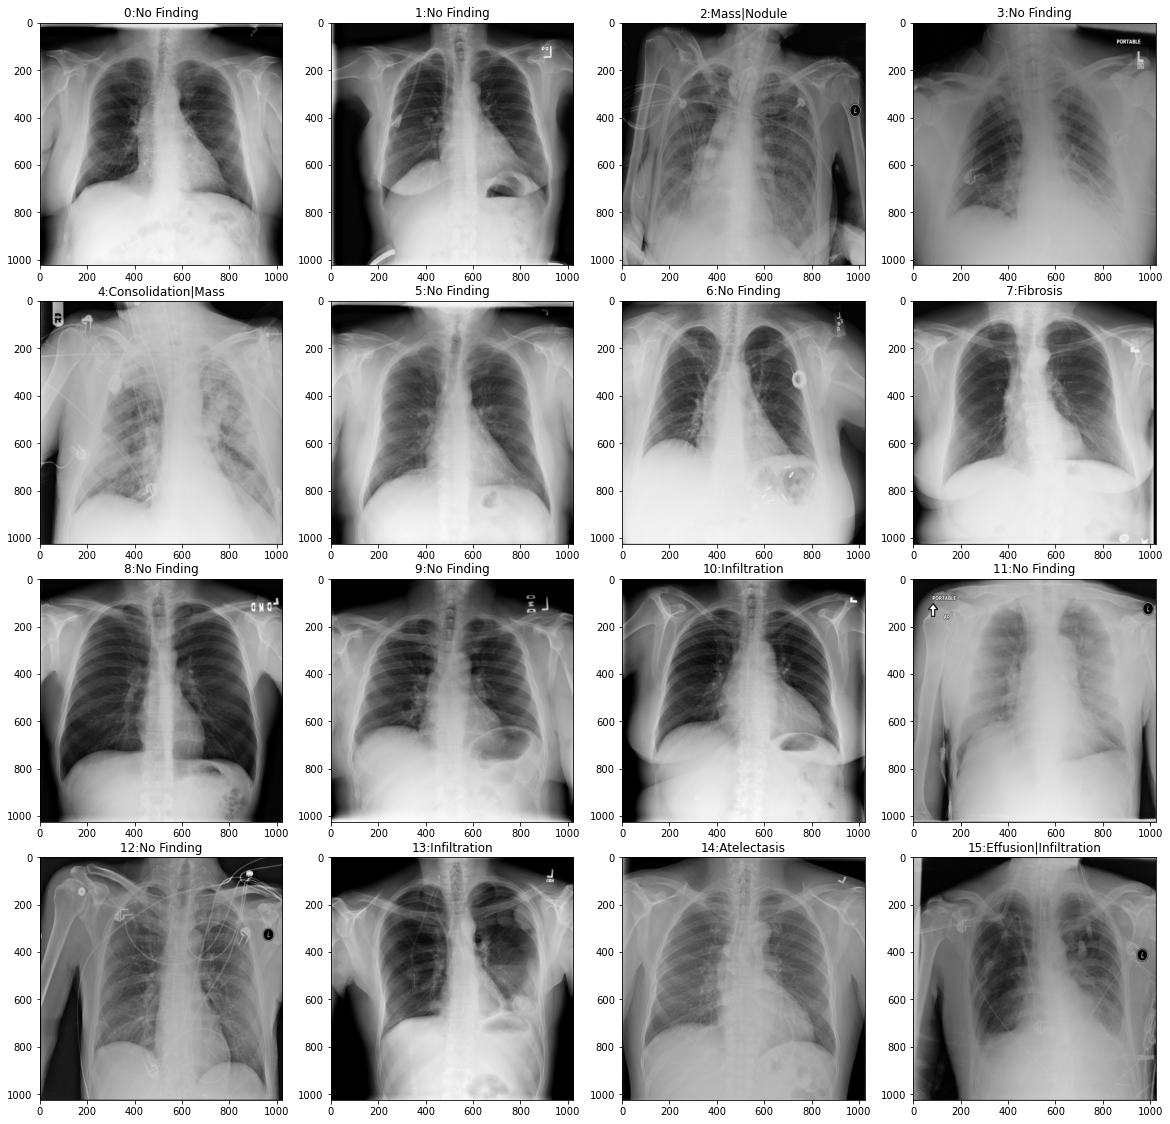

In [27]:
# Define function to display specified number of x-ray images randomly selected as a grid
def image_random_selection_display(df, rows, cols, figx, figy):
    
    # Define grid of image plots
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(figx, figy))
    fig.subplots_adjust(hspace=0.1)
    # Randomly sample required images
    rand_sample_df = df.sample(rows*cols, random_state=42)
    rand_sample_df.reset_index(drop=True, inplace=True)
    # For each axes 
    for index, ax in enumerate(axes.flatten()):
        # Read image
        img = mpimg.imread(rand_sample_df['path'][index])
        # Display image
        ax.imshow(img,cmap='gray')
        # Set image title as number + label/s
        ax.set_title(str(index) + ':' + rand_sample_df['Finding Labels'][index]) 

# Show images
image_random_selection_display(sample_df, 4, 4, 20, 20)

In [28]:
# For the same set of images above, let us look at the image dimensions & intensity ranges
rand_sample_df = sample_df.sample(16, random_state=42)
rand_sample_df.reset_index(drop=True, inplace=True)
# For each axes 
for index in range(16):
    # Read image
    img = mpimg.imread(rand_sample_df['path'][index])
    # Show dimensions
    print(img.shape)
    # Show max & min values
    values = img.ravel()
    print('Max intensity: ' + str(max(values)) + ' Min intensity: ' + str(min(values)))

(1024, 1024)
Max intensity: 0.9607843 Min intensity: 0.0
(1024, 1024)
Max intensity: 0.99607843 Min intensity: 0.0
(1024, 1024)
Max intensity: 1.0 Min intensity: 0.0
(1024, 1024)
Max intensity: 1.0 Min intensity: 0.0
(1024, 1024)
Max intensity: 0.94509804 Min intensity: 0.003921569
(1024, 1024)
Max intensity: 0.9647059 Min intensity: 0.0
(1024, 1024)
Max intensity: 1.0 Min intensity: 0.0
(1024, 1024)
Max intensity: 1.0 Min intensity: 0.0
(1024, 1024)
Max intensity: 1.0 Min intensity: 0.0
(1024, 1024)
Max intensity: 0.9647059 Min intensity: 0.0
(1024, 1024)
Max intensity: 0.9647059 Min intensity: 0.0
(1024, 1024)
Max intensity: 1.0 Min intensity: 0.0
(1024, 1024)
Max intensity: 1.0 Min intensity: 0.0
(1024, 1024)
Max intensity: 0.98039216 Min intensity: 0.0
(1024, 1024)
Max intensity: 0.81960785 Min intensity: 0.0
(1024, 1024)
Max intensity: 1.0 Min intensity: 0.0


So from this random selection of 16 x-ray images we can observe the following:

- The images are single channel, greyscale images
- The images are 1024 x 1024 pixels square
- The image intensity values range from 1.0 to 0.0
- The images all cover the thorasic area of the body
- The images seem to be a mixture of male and female bodies i.e. we are able to observe a breast outline in some images such as image 1 & 7
- We can observe the presence of foriegn bodies in some images i.e. 12 which may be things such as wires
- We can observe some images are blurry such as image 3 & 12. This may be due to the subject moving during the x-ray

#### 2.3.2 Filtering out the background from images

The black background pixels in the images will not help us when we will look at the image intensity profiles of each disease if we want to try and observe the unique characteristics of each disease, as they will create huge peaks at zero that will distort the plots and make it much harder to observe the characteristics of the image intensities of the actual body parts. 

We will here attempt to use Otsu's method to try and filter out background pixels from images & their intensity distributions which will will later incorporate into your detailed expoloration of each disease.

Let us first define some functions to display the intensity profiles & images of different diseases.

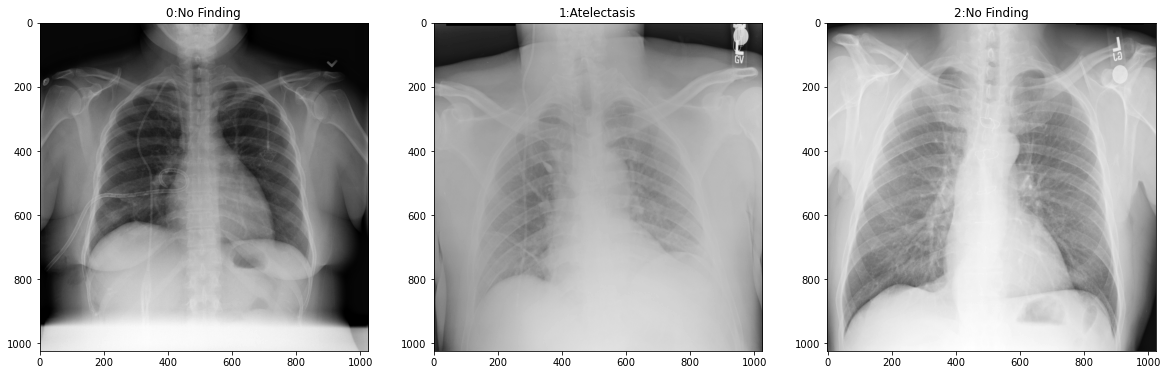

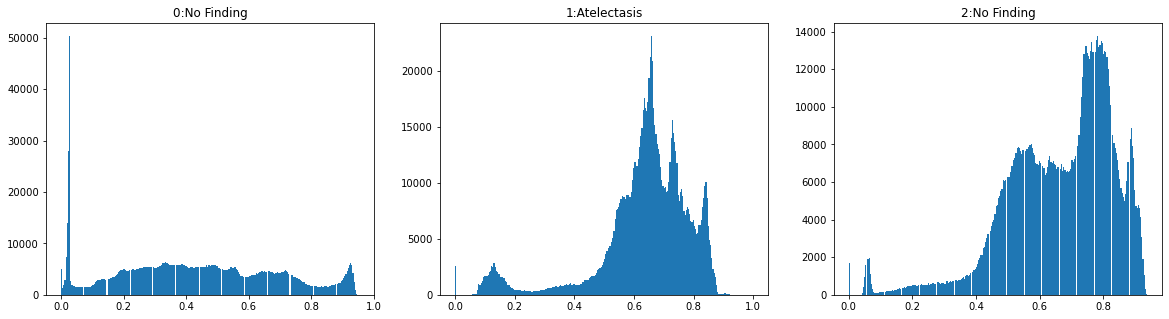

In [49]:
def plot_intensity_histogram(label_sample_df):
    # Define grid of histogram plots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    fig.subplots_adjust(hspace=0.1)
    # For each axes 
    for index, ax in enumerate(axes.flatten()):
        # Read image
        img = mpimg.imread(label_sample_df['path'][index])
        # Flatten img array
        img = img.ravel()
        # Display histogram of intensities
        ax.hist(img, bins = 256)
        # Set image title as number + label/s
        ax.set_title(str(index) + ':' + label_sample_df['Finding Labels'][index]) 

# Select random sample from df
def select_sample(df):
    # Randomly sample required images
    rand_sample_df = df.sample(3)
    rand_sample_df.reset_index(drop=True, inplace=True)
    return rand_sample_df

def random_sample_display(df):
    # Define grid of image plots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.1)
    # Randomly sample required images
    label_sample_df = select_sample(df)
    # For each axes 
    for index, ax in enumerate(axes.flatten()):
        # Read image
        img = mpimg.imread(label_sample_df['path'][index])
        # Display image
        ax.imshow(img,cmap='gray')
        # Set image title as number + label/s
        ax.set_title(str(index) + ':' + label_sample_df['Finding Labels'][index]) 
        
    # Plot intensity histograms for these images
    plot_intensity_histogram(label_sample_df)
        
# Display a random sample of images and distributions
random_sample_display(sample_df)

So we can see the background images (black) pixel values seem to occur at around 0, which also make it hard to compare the distributions. Lets see if we can use Otsu's method to filter these out from the distributions.

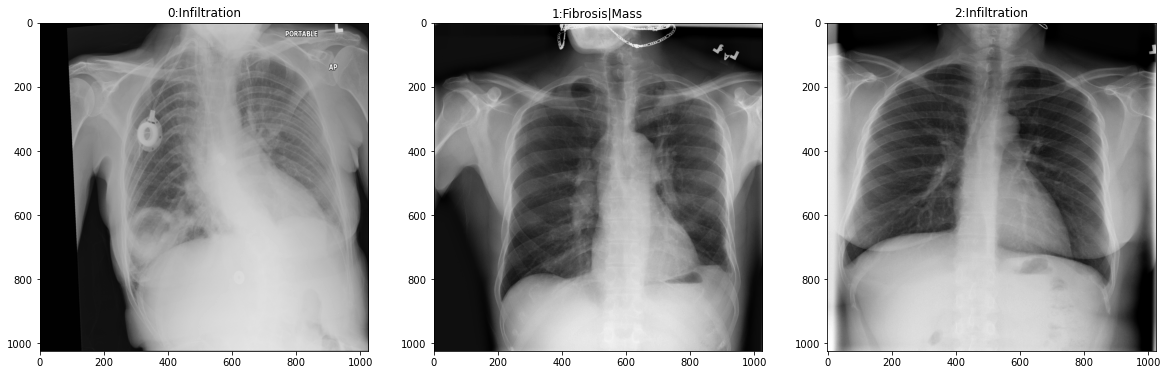

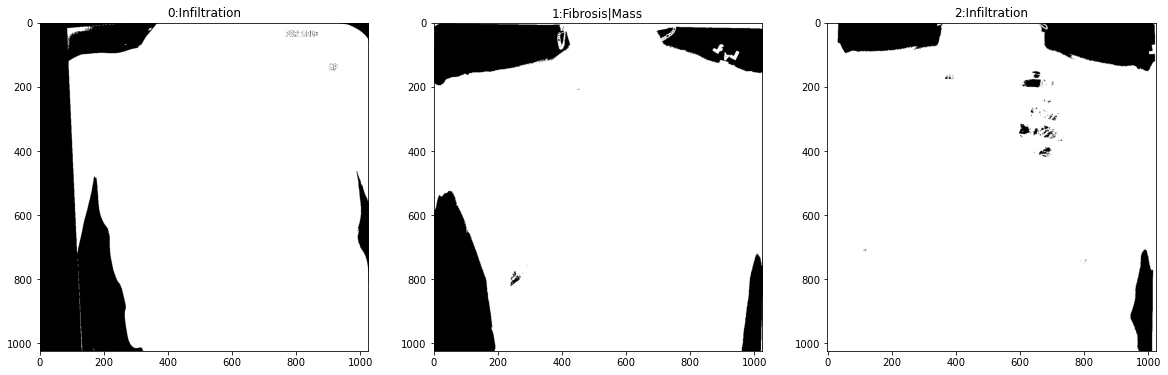

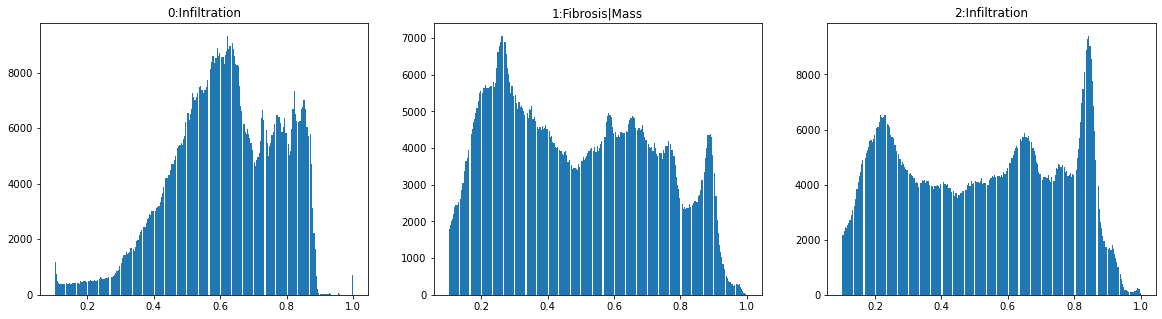

In [50]:
otsu_threshold = 0.1

def otsu_background_mask(image_array):
    image_masked = (image_array > otsu_threshold)
    return image_masked

def otsu_background_filter(image_array):
    image_mask = otsu_background_mask(image_array)
    image_filtered = image_array[image_mask]
    return image_filtered

def otsu_plot_intensity_histogram(label_sample_df):
    # Define grid of histogram plots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    fig.subplots_adjust(hspace=0.1)
    # For each axes 
    for index, ax in enumerate(axes.flatten()):
        # Read image
        img = mpimg.imread(label_sample_df['path'][index])
        # Flatten img array
        img = img.ravel()
        # Apply otsu filter
        img = otsu_background_filter(img)
        # Display histogram of intensities
        ax.hist(img, bins = 256)
        # Set image title as number + label/s
        ax.set_title(str(index) + ':' + label_sample_df['Finding Labels'][index]) 

def otsu_random_sample_display(df):
    # Define grid of image plots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.1)
    # Randomly sample required images
    label_sample_df = select_sample(df)
    # For each axes 
    for index, ax in enumerate(axes.flatten()):
        # Read image
        img = mpimg.imread(label_sample_df['path'][index])
        # Display image
        ax.imshow(img,cmap='gray')
        # Set image title as number + label/s
        ax.set_title(str(index) + ':' + label_sample_df['Finding Labels'][index]) 
        
    # Replot images with otsu mask
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.1)
    # For each axes 
    for index, ax in enumerate(axes.flatten()):
        # Read image
        img = mpimg.imread(label_sample_df['path'][index])
        # Apply otsu mask
        img_mask = otsu_background_mask(img)
        # Display image
        ax.imshow(img_mask,cmap='gray')
        # Set image title as number + label/s
        ax.set_title(str(index) + ':' + label_sample_df['Finding Labels'][index]) 
        
    # Plot intensity histograms for these images
    otsu_plot_intensity_histogram(label_sample_df)
    
otsu_random_sample_display(sample_df)

For a filter value of 0.1 this seems to have removed the background pixels quite well. Lets see for some more random selections.

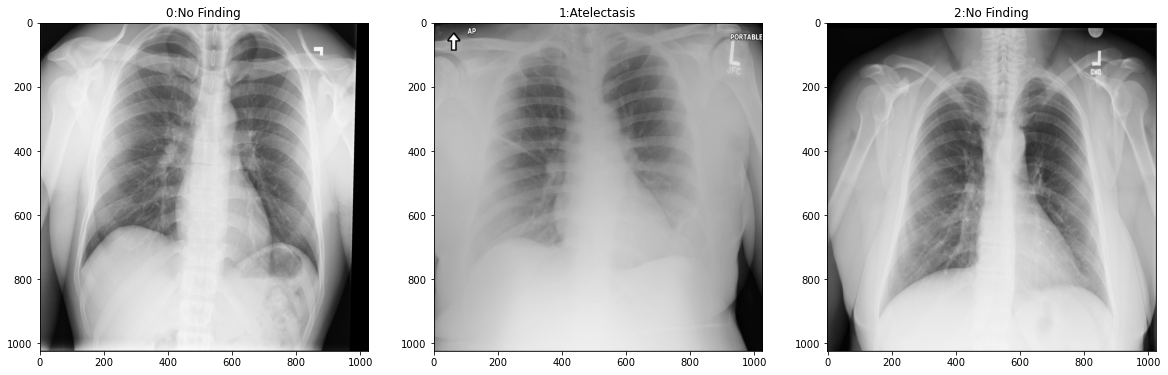

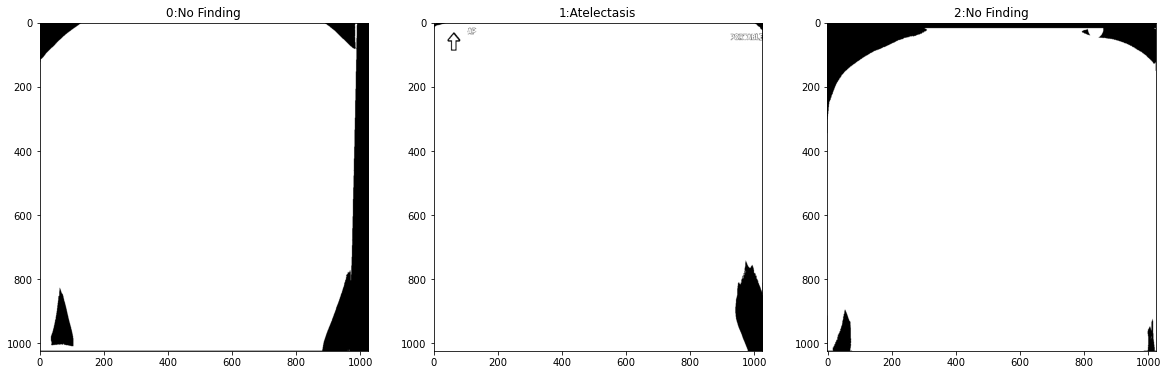

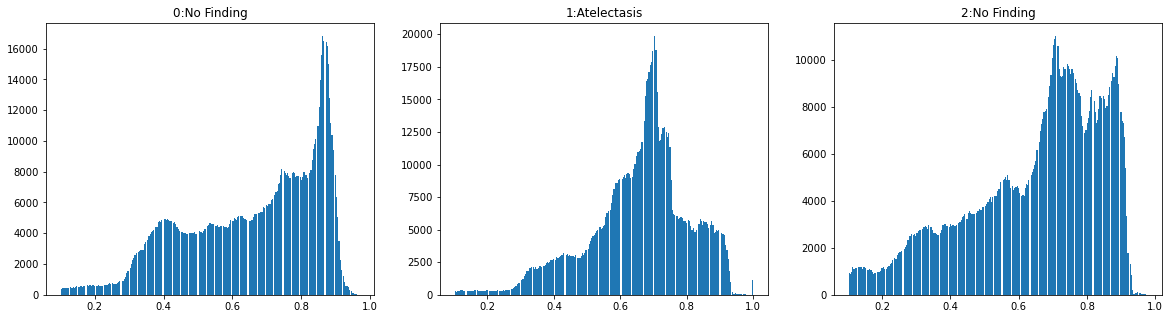

In [51]:
otsu_random_sample_display(sample_df)

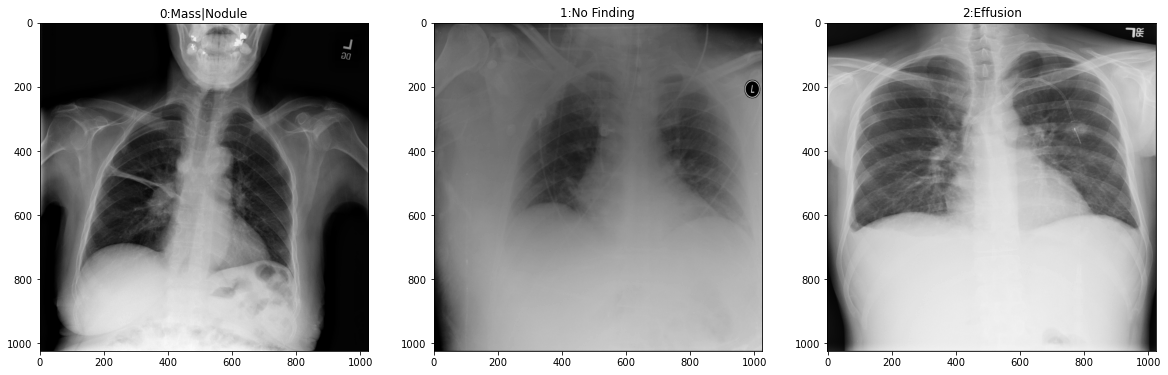

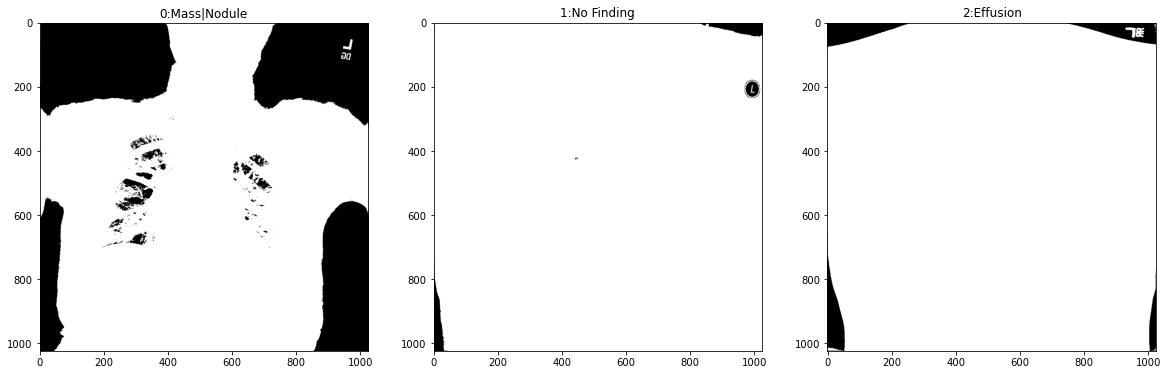

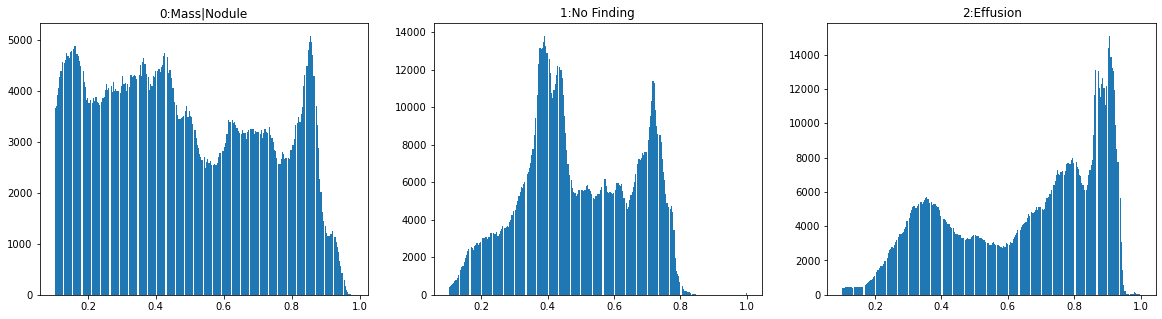

In [52]:
otsu_random_sample_display(sample_df)

So this seems to have removed the background pixels quite well from a range of different disease types. We will incorporate this otsu filtering of background pixels into our more detailed examination.

#### 2.3.3 Exploration of intensity profiles for each disease in dataset

We will look at 3 example images for each disease from the smaller sample dataset, as well as 3 image intensity distributions for these images, as well as an aggregate distribution for x5 images. We will also compare each non Pneumonia disease to Pneumonia for each of these histograms - to allow us to observe key differences between Pneumonia and other diseases.

The dataset is multi-label i.e. each image could have multiple labels. When trying to understand potential unique aspects of a distribution for a particular disease, multi-label examples could therefore prove more difficult to observe what is unique to each disease/label. 

For my explorations I will then choose only examples for each disease that are labelled with only 1 disease, making it more likely I can identify any aspects of the intensity distribution that is unique to a particular disease from the x-ray images.

In [147]:
# Recap of all disease label names
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [55]:
# Select random sample from df for a label, where sample has pure examples of only that label
def select_label_sample(df, label):
    # Select images for given label only
    label_df = df[df['Finding Labels'] == label]
    # Randomly sample required images
    rand_sample_df = label_df.sample(3, random_state=42)
    rand_sample_df.reset_index(drop=True, inplace=True)
    return rand_sample_df

# Normalise an image
def normalise_image_values(image):
    image_normalised = image.copy().ravel()
    mean_intensity = np.mean(image_normalised)
    stddev_intensity = np.std(image_normalised)
    image_normalised = (image_normalised - mean_intensity)/stddev_intensity
    return image_normalised

In [58]:
def get_aggregate_distribution(df, label):
    all_image_intensities = []
    type(all_image_intensities)
    # Select all rows for given label
    label_df = df[df['Finding Labels'] == label]
    label_df = label_df.sample(5, random_state=42)
    # For each row of this label
    for i in label_df.index: 
        # Get image
        img = mpimg.imread(label_df['path'][i])
        # Flatten img array
        img = img.ravel()
        # Apply otsu filter
        img = otsu_background_filter(img)
        # Append this images intensities
        all_image_intensities.extend(img)
        
    return all_image_intensities
      
pneumonia_intensities = get_aggregate_distribution(sample_df, 'Pneumonia')

In [71]:
def plot_aggregate_distribution(df, label):
    binsize = 256
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    label_intensities = get_aggregate_distribution(sample_df, label)
    axes[0].hist(label_intensities, bins=binsize)
    axes[0].set_title(label + ': x5 samples') 
    # If not Pneumonia
    if label != 'Pneumonia':
        axes[1].hist(pneumonia_intensities, bins=binsize)
        axes[1].set_title('Pneumonia: x5 samples') 

In [72]:
# Define function to display specified number random images together with itensity profiles for a specified label
def image_intensity_selection_display(df, label):
    # Define grid of image plots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.1)
    # Randomly sample required images
    label_sample_df = select_label_sample(df, label)
    # For each axes 
    for index, ax in enumerate(axes.flatten()):
        # Read image
        img = mpimg.imread(label_sample_df['path'][index])
        # Display image
        ax.imshow(img,cmap='gray')
        # Set image title as number + label/s
        ax.set_title(str(index) + ':' + label_sample_df['Finding Labels'][index]) 
        
    # Plot intensity histograms for these images using otsu background filtering
    otsu_plot_intensity_histogram(label_sample_df)
        
    # If not Pneumonia
    if label != 'Pneumonia':
        # Randomly sample same Pneumonia images
        pneumonia_sample_df = select_label_sample(df, 'Pneumonia')
        # Plot intensity histograms for these Pneumonia images (with otsu background filtering)
        otsu_plot_intensity_histogram(pneumonia_sample_df)
    
    plot_aggregate_distribution(df, label)

#### Intensity distribution of Pneumonia cases

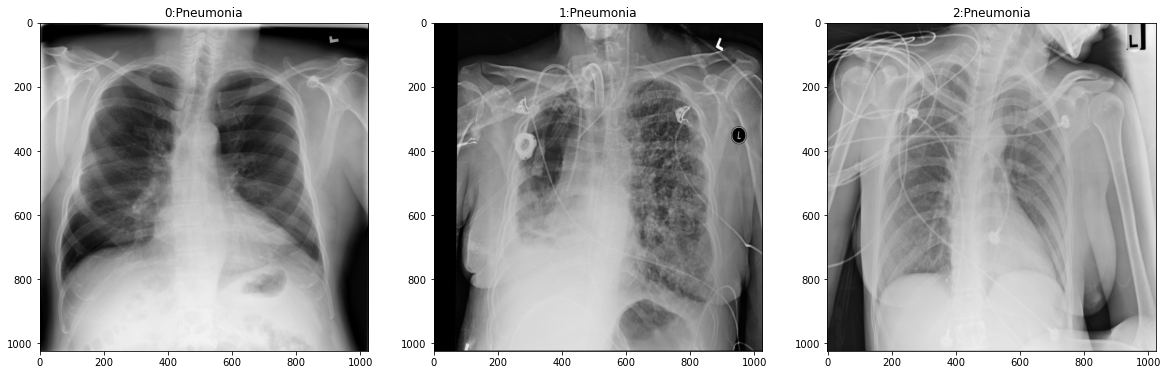

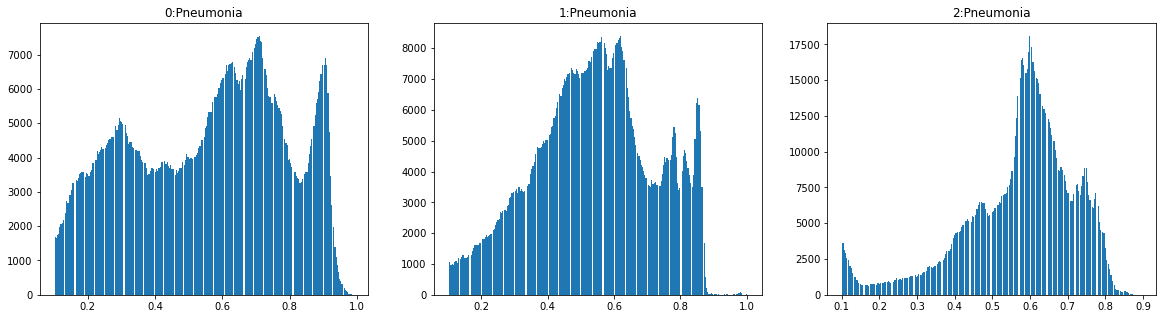

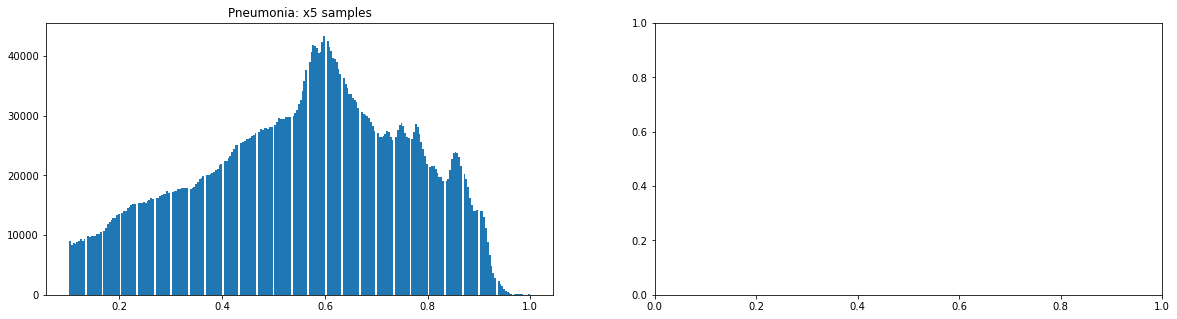

In [73]:
# Show x-rays & intensity distributions
image_intensity_selection_display(sample_df, 'Pneumonia')

Generally in the 3 individual images and the aggregate distribution of intensity values of x5 images with Pneumonia, we can see a main central peak in intensity at around 0.6 seems to be a charactertistic of the profile for this disease.

#### Intensity distribution of No Finding cases

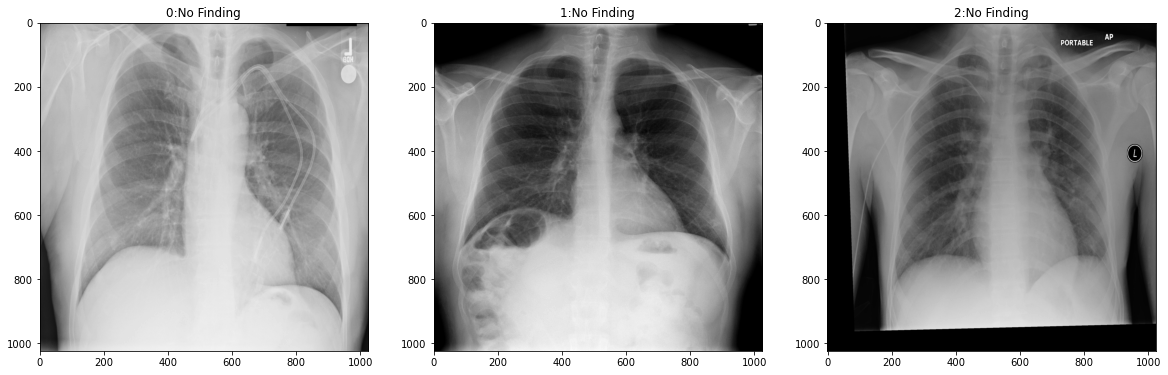

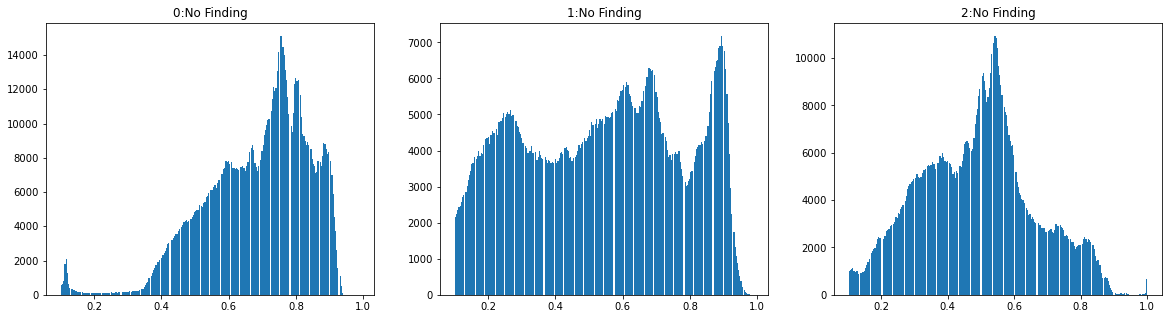

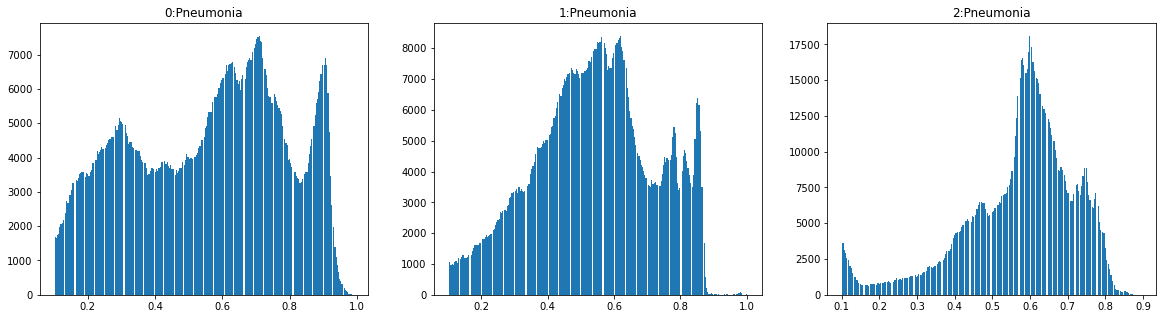

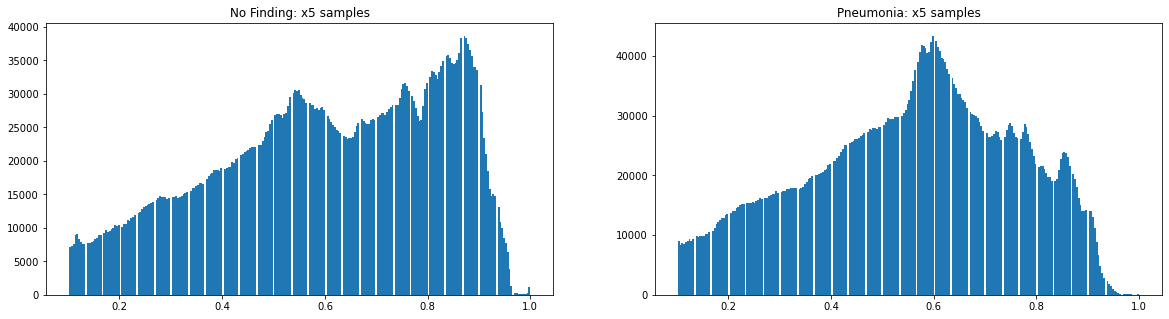

In [74]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'No Finding')

So for No Finding i.e. no disease, we can observe from the distributions there are two very minor peaks in the distributions around 0.5 and 0.9.

We can see a clear difference to the distribution profile for No Finding when compared to Pneumonia, with its clear single peak (bar 0 outlier) at around 0.6 for Pneumonia.

#### Intensity distribution of Atelectasis cases

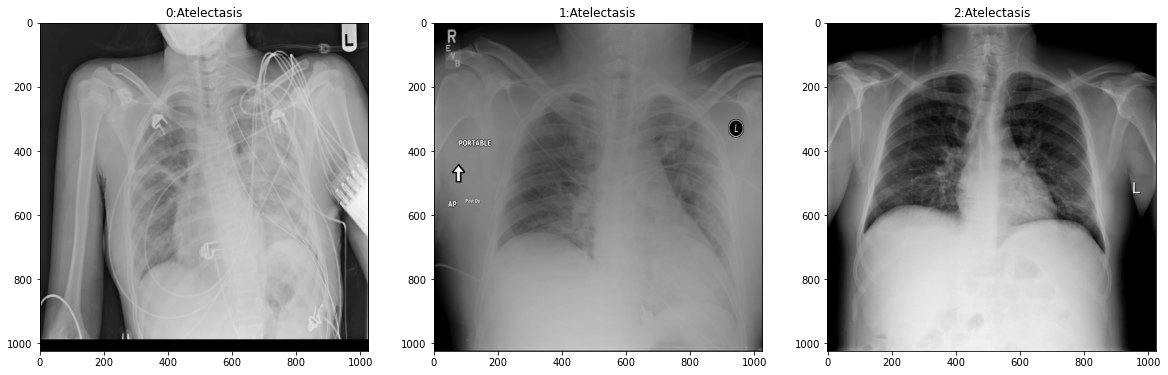

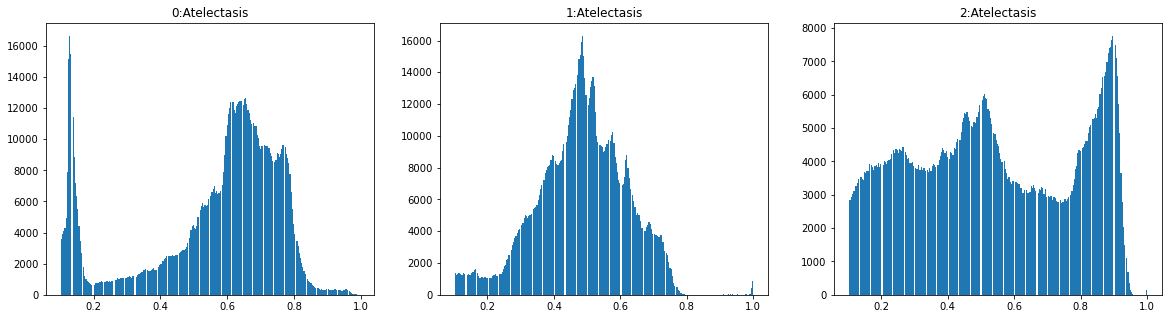

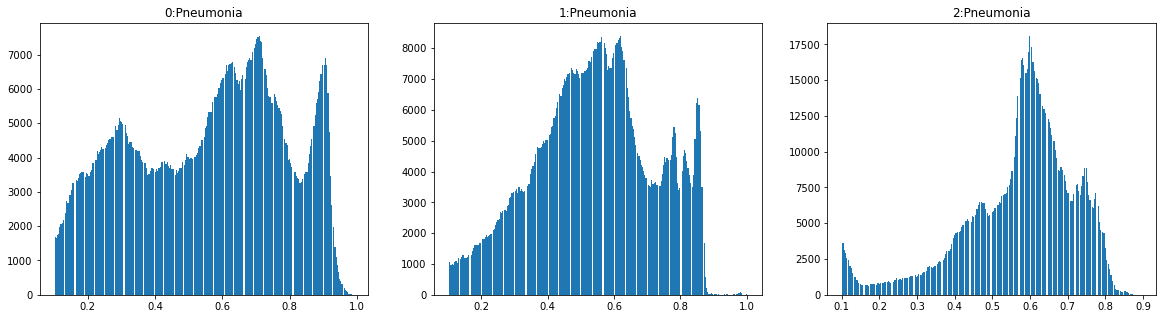

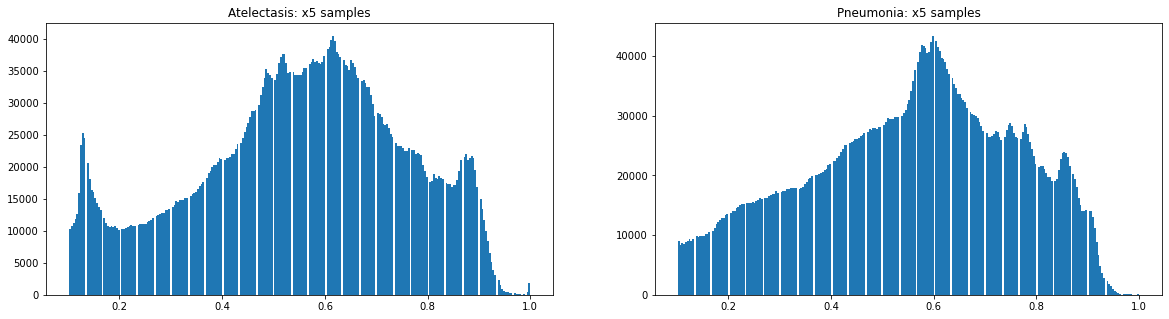

In [75]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Atelectasis')

Atelectasis does appear to have a very similar distribution profile to Pneumonia - with a peak around 0.6 and a very similar shaped distribution, though with a wider peak.

#### Intensity distribution of Cardiomegaly cases

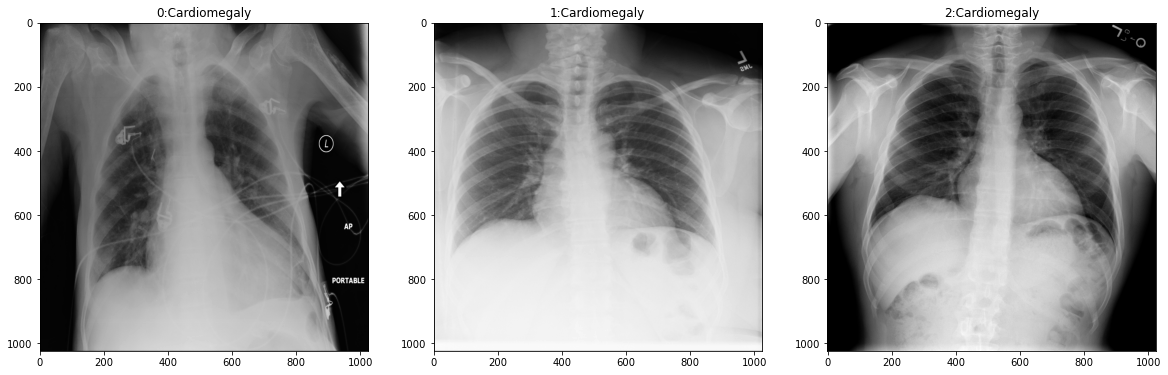

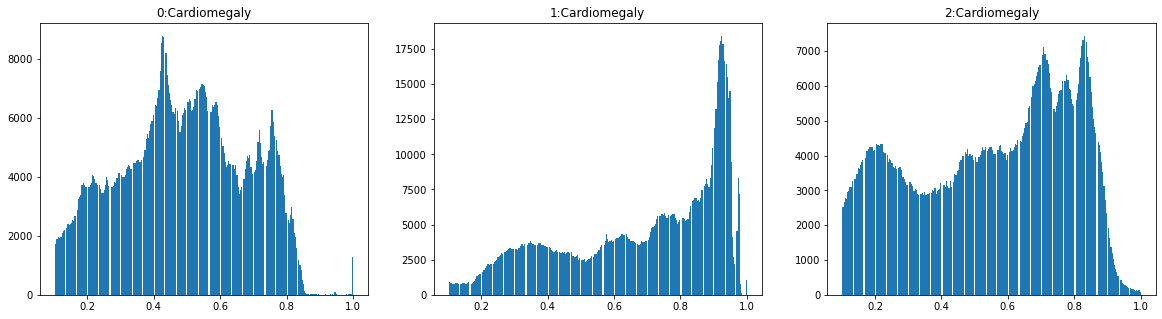

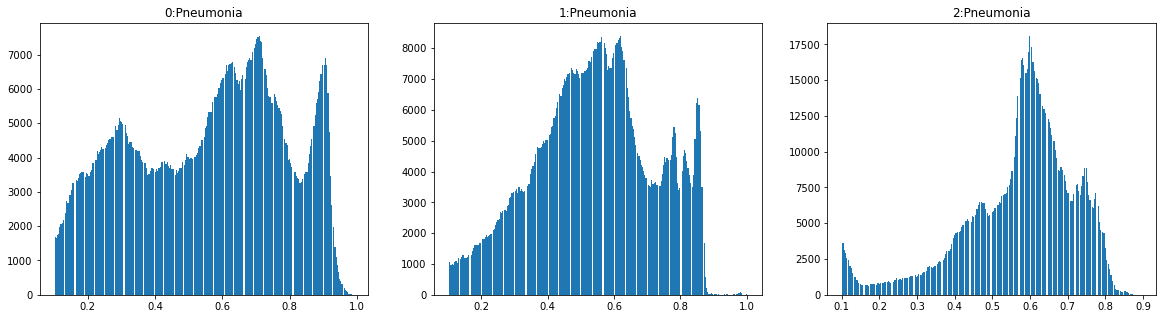

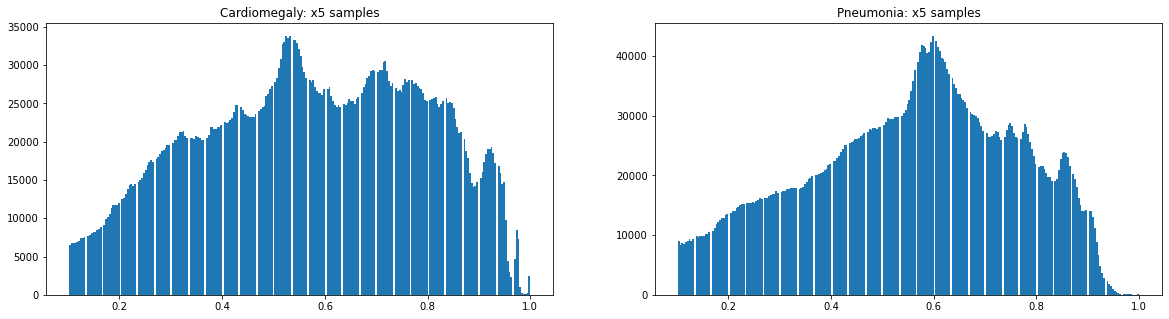

In [76]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Cardiomegaly')

Cardiomegaly appears to have quite a 'tabletop' distribtution - whos peak is at around 0.5.

The second image has a peak nearer 1 due to much more white in the image, probably due to more dense mateirial in the body of this particular person.

More generally, Cardiomegaly distributions contrast with the clear peak the Pneumonia distribution has at 0.6.

#### Intensity distribution of Consolidation cases

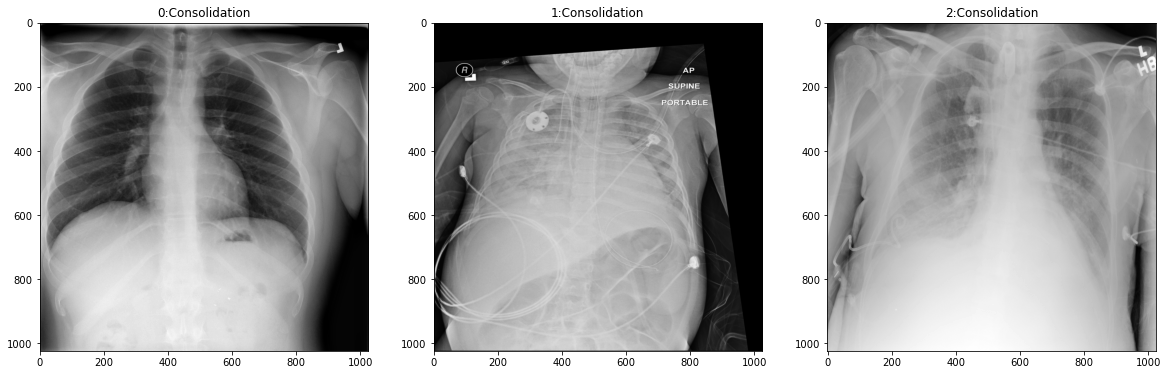

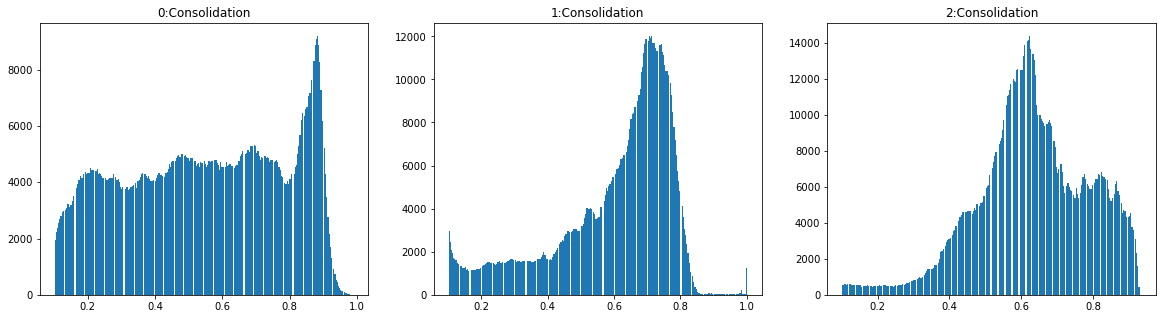

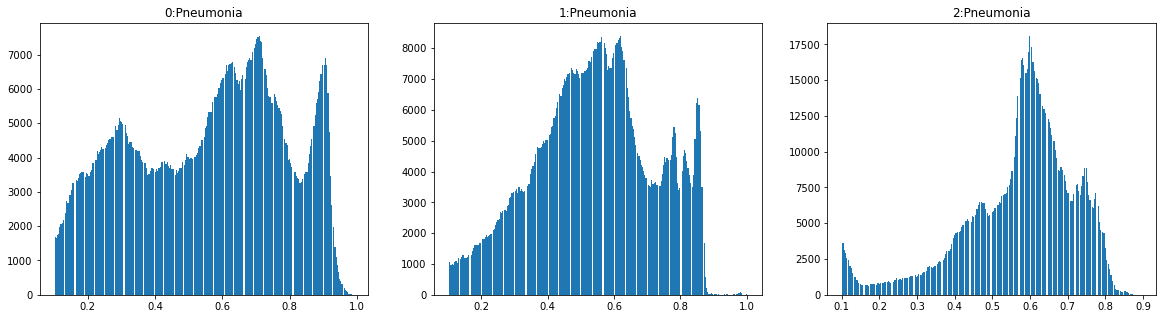

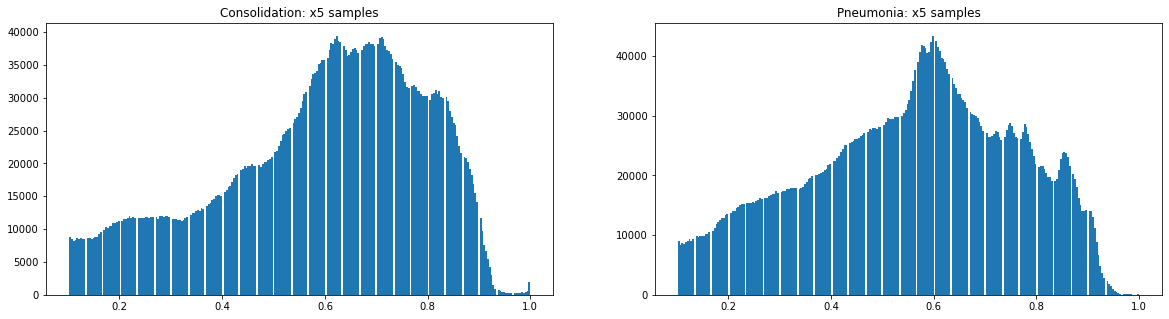

In [77]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Consolidation')

So for the Consolidation cases we see a more levelled peak that ranges between 0.6-0.8.

We also see fewer values between 0.2-0.4 when compared to Pneumonia cases, as is a lack of a clear peak at 0.6 as with Pneumonia cases.

#### Intensity distribution of Edema cases

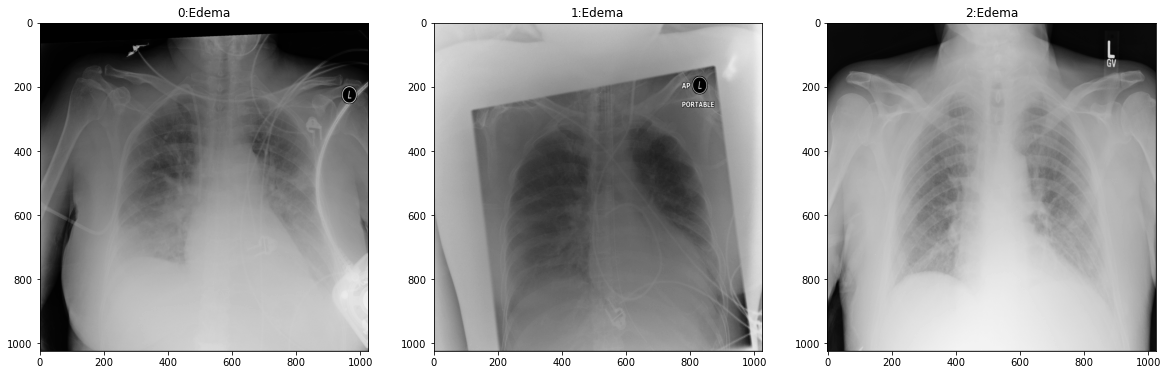

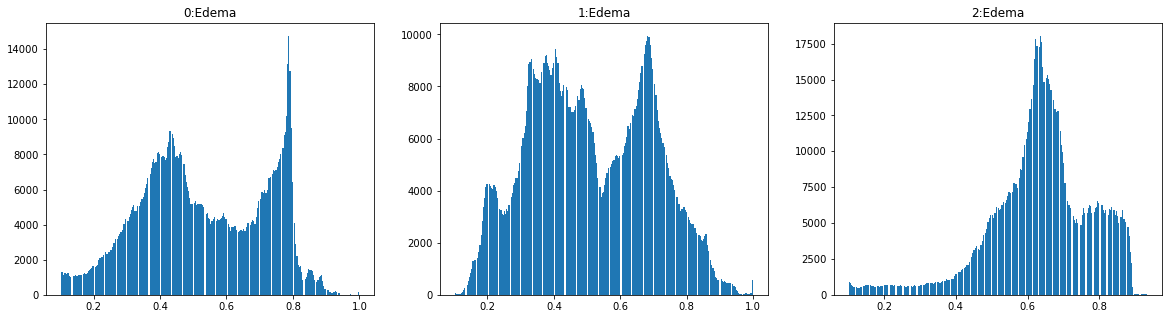

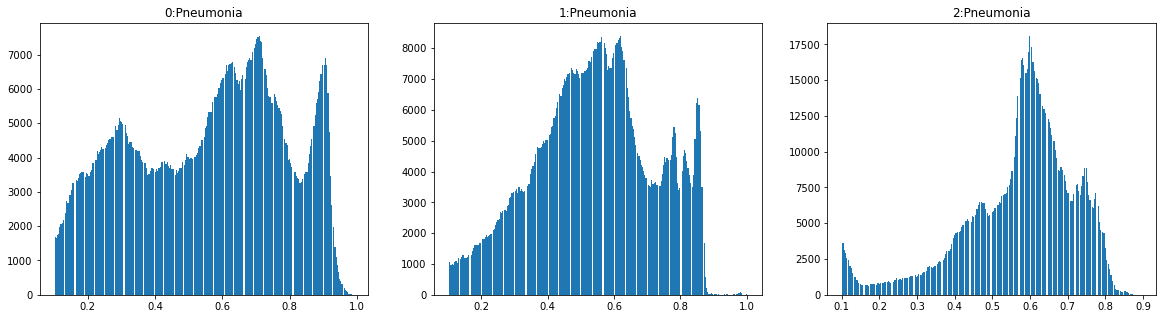

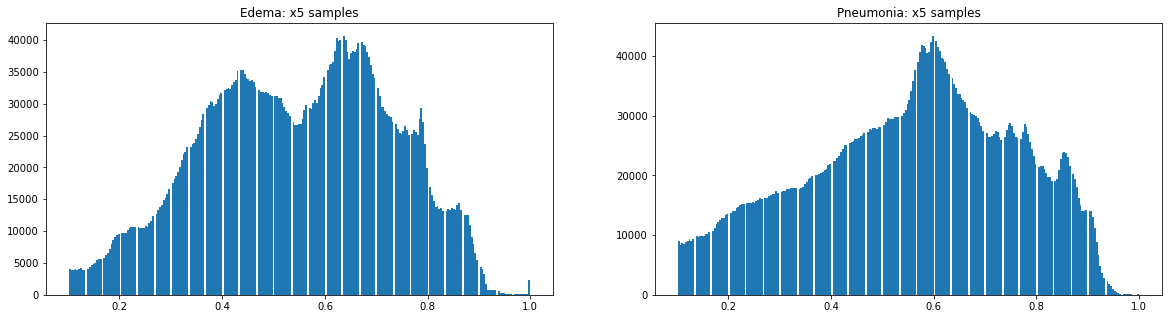

In [78]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Edema')

For Edema cases we see an interesting 'twin peak' profile in the distribution, with sharp peaks at around 0.4 and 0.6. This is seen more clearly in the aggregate x5 sample view.

This contrasts with the Pneuomia case which have a single main sharp peak at 0.6.

#### Intensity distribution of Effusion cases

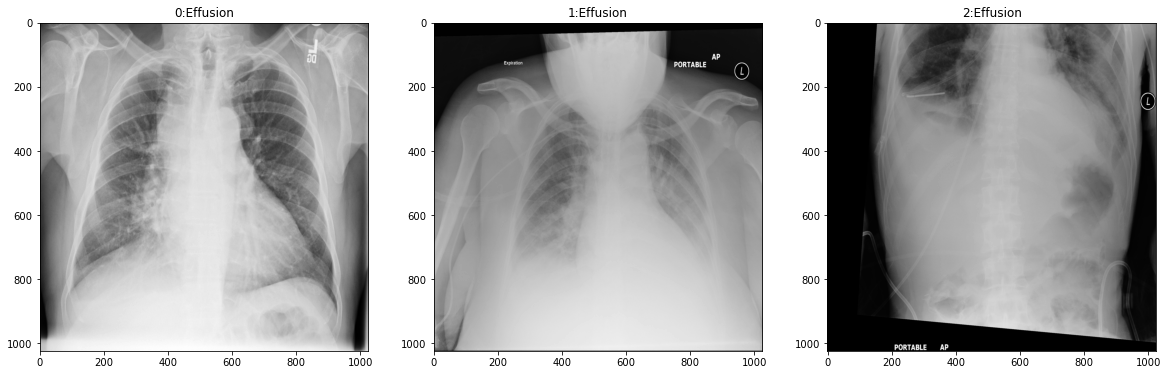

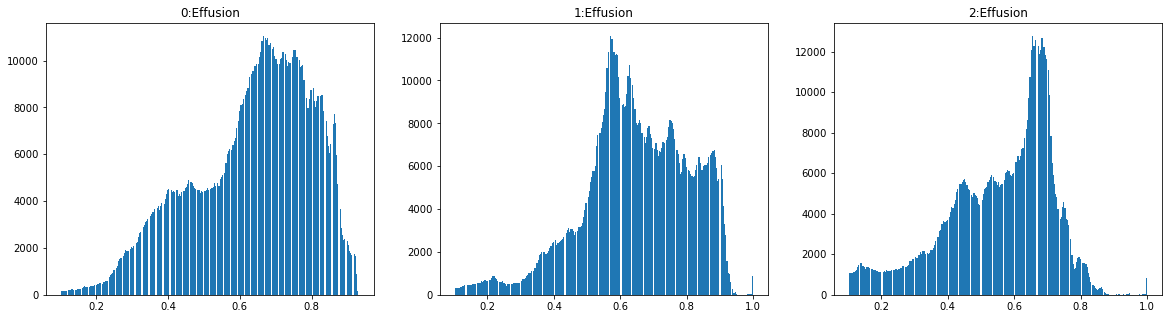

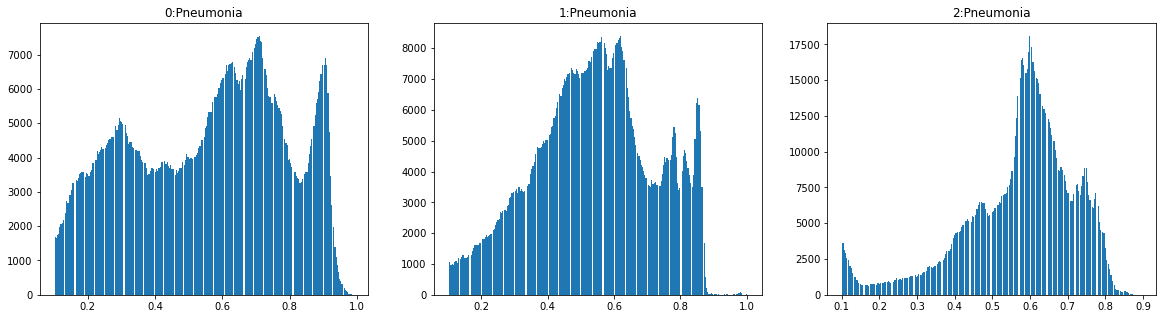

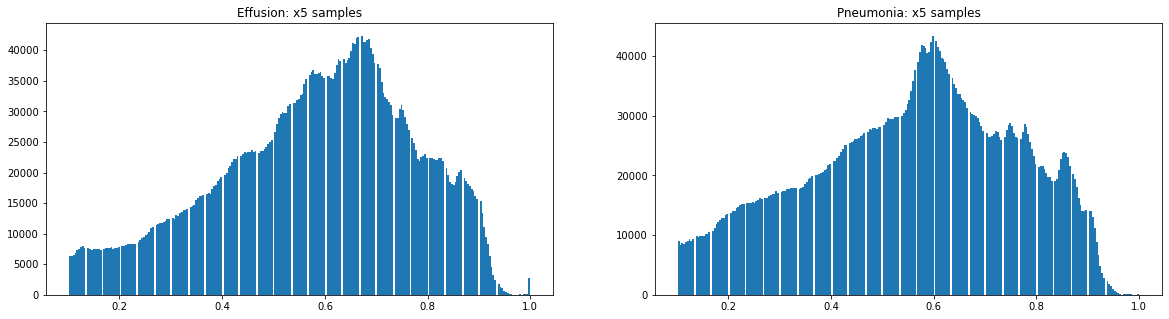

In [79]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Effusion')

Effusion cases do have a similar distribution profile to the Pneuomia cases - however one key difference is in the sharpness of the peak - the Effusion cases have only a slight peak at 0.7, whereas the Pneuomia cases have a much stronger peak at 0.6.

We can see this more clearly in the aggregate x5 distributions.

#### Intensity distribution of Emphysema cases

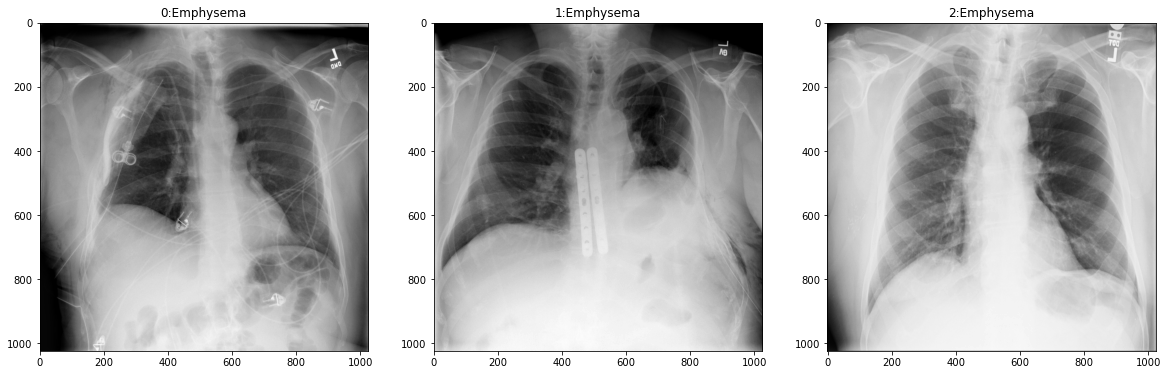

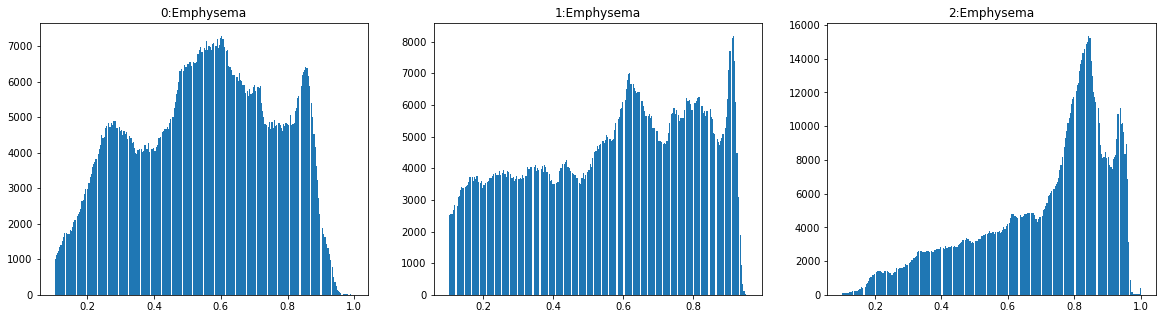

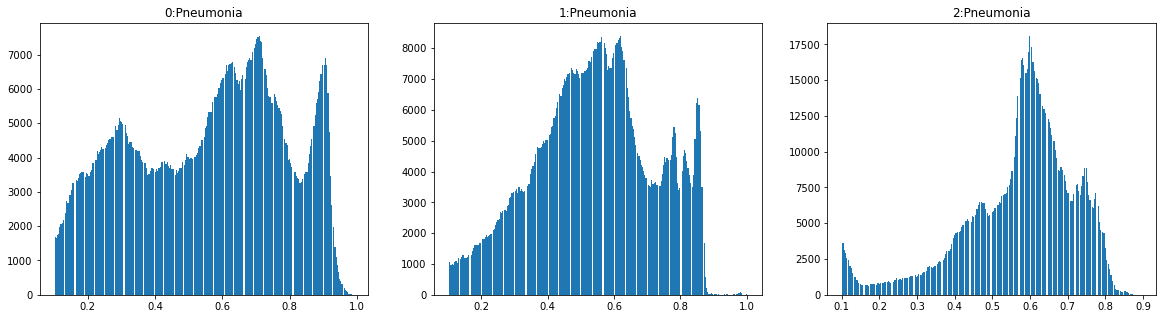

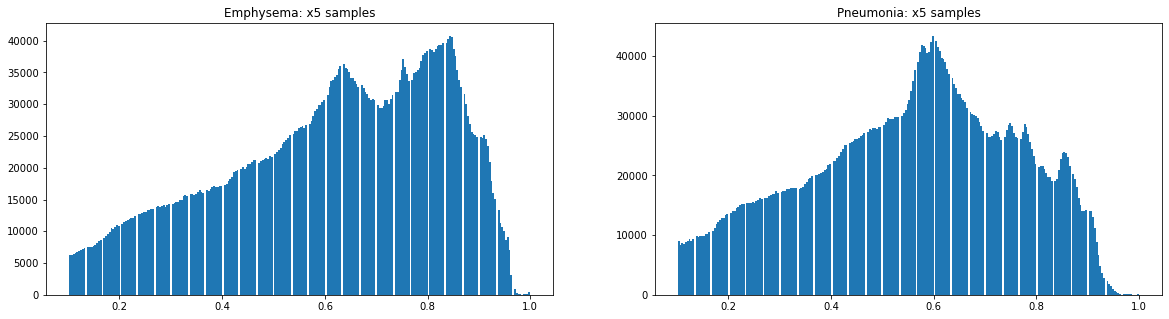

In [80]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Emphysema')

Emphysema cases have an interesting 'twin peak' profile with peaks at around 0.6 and 0.8. The distribution is also more l-shaped or long tailed, rather than more normal or bell-shaped. They also have far less values at 0 than other diseases.

We can distinguish these from the Pneumonia cases, which has a single main peak at 0.6.

#### Intensity distribution of Fibrosis cases

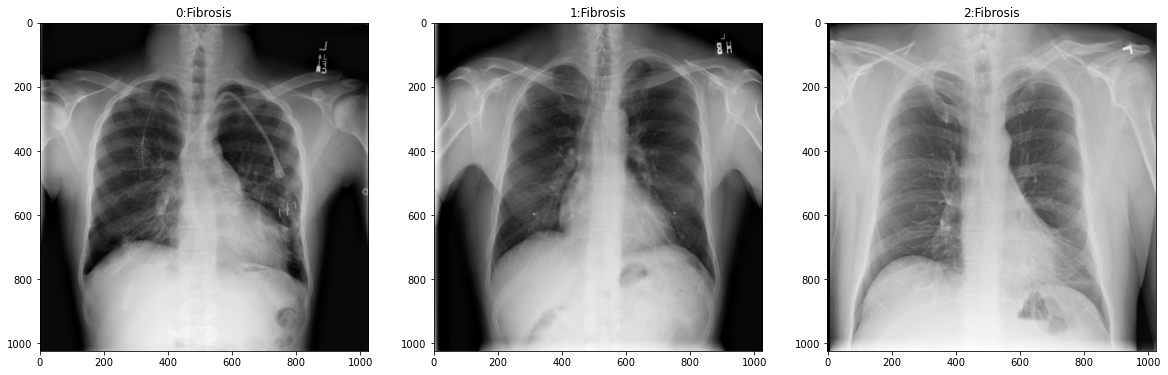

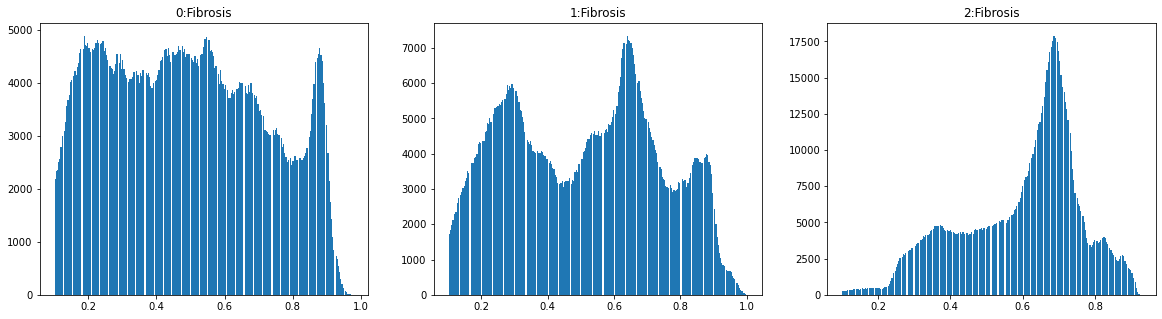

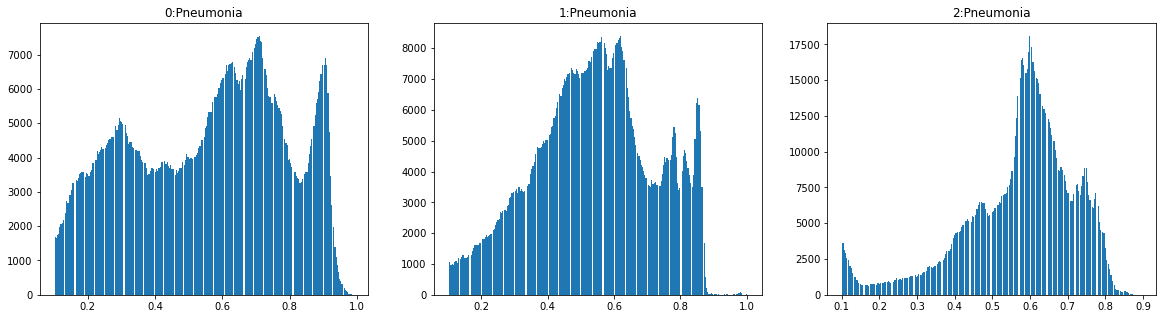

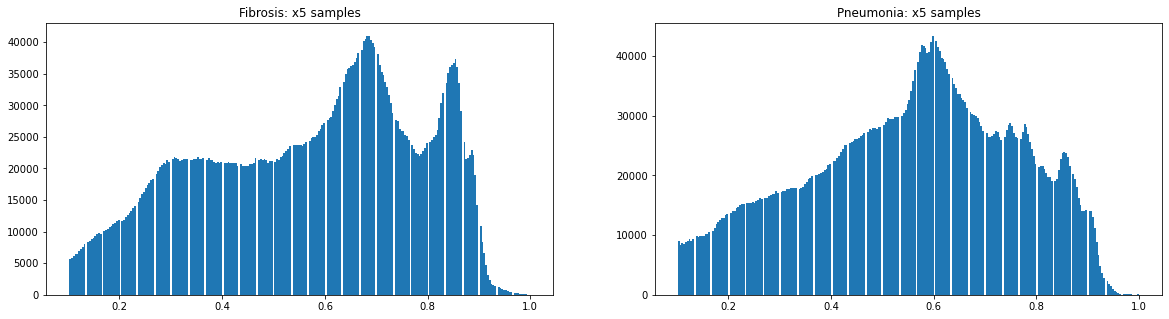

In [81]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Fibrosis')

So Fibrosis cases seem to have two peaks rought around 0.7 and 0.9.

This contrasts with the Pneumonia cases which tend to have a distinct peak around 0.6.

#### Intensity distribution of Hernia cases

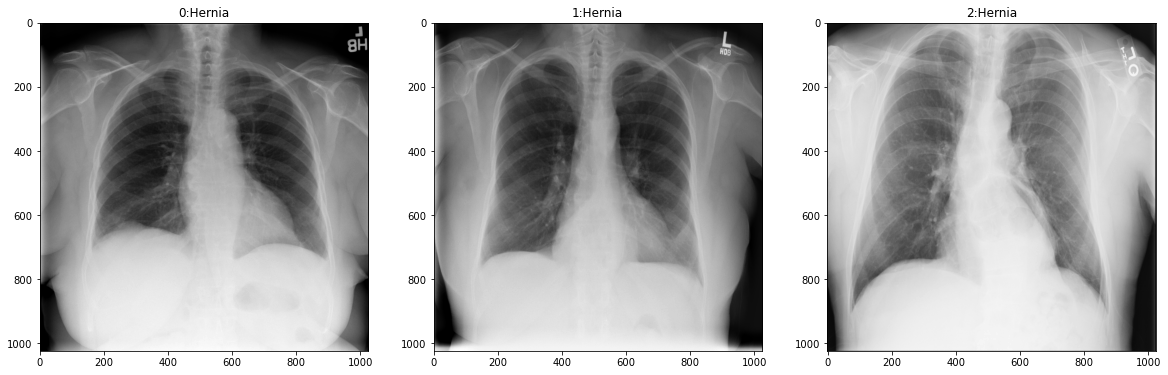

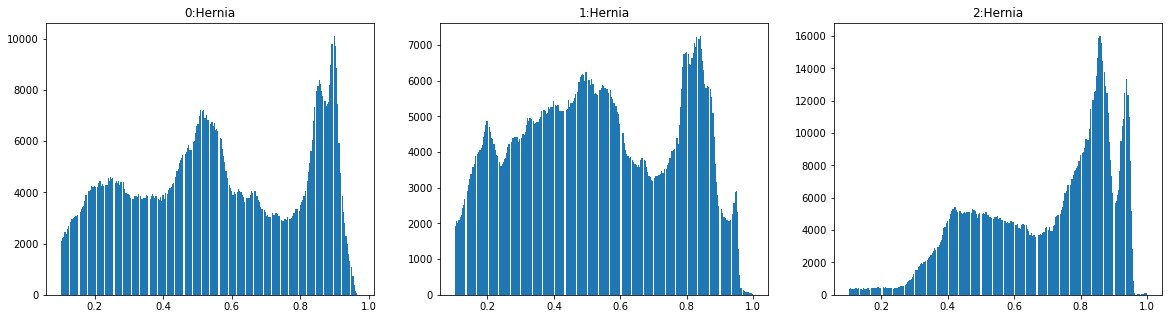

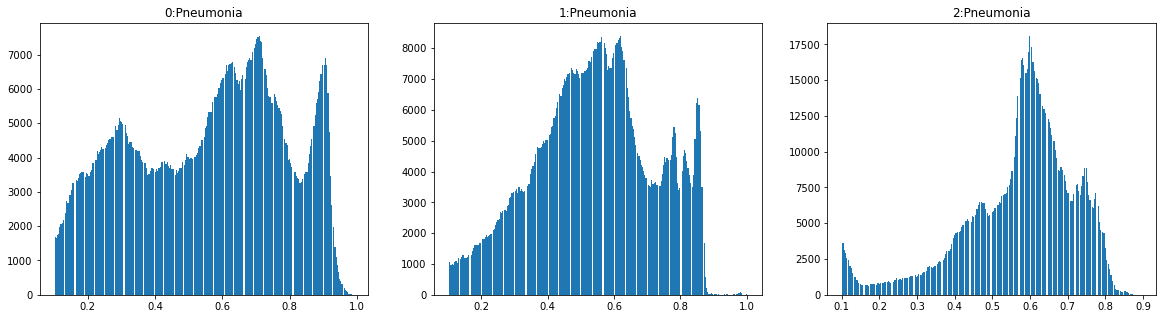

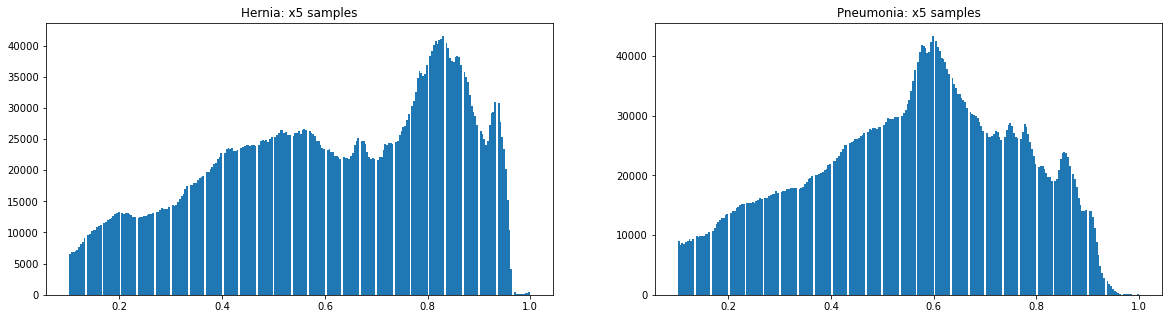

In [82]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Hernia')

Hernia cases also seem to have a peak at around 0.8.

This is different from the Pneumonia cases that have a clear singular peak at around 0.6.

#### Intensity distribution of Infiltration cases

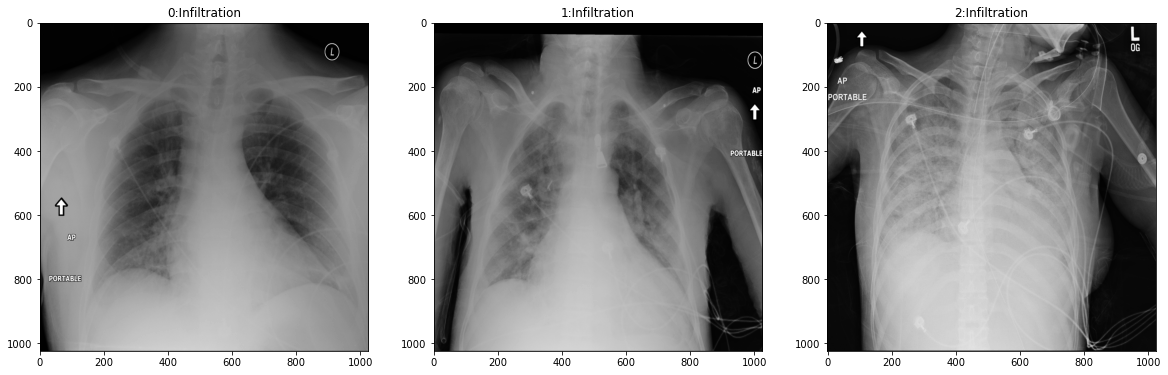

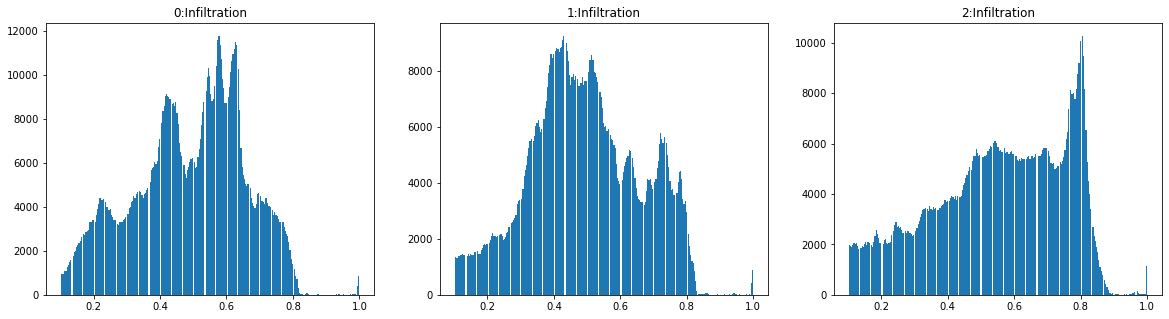

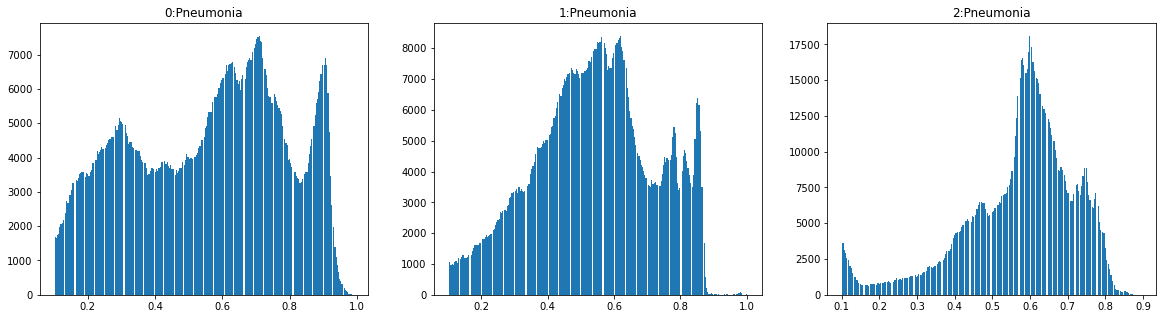

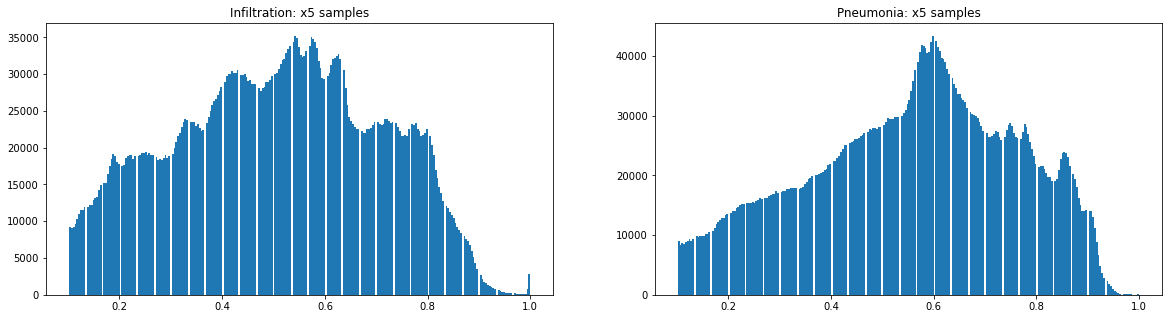

In [83]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Infiltration')

So for Infiltration cases there seems to be no clear peak looking accross different examples, just a higher plateau area between 0.5-0.6.

This contrasts with the clear peak we tend to see in the Pneumonia cases around 0.6

#### Intensity distribution of Mass cases

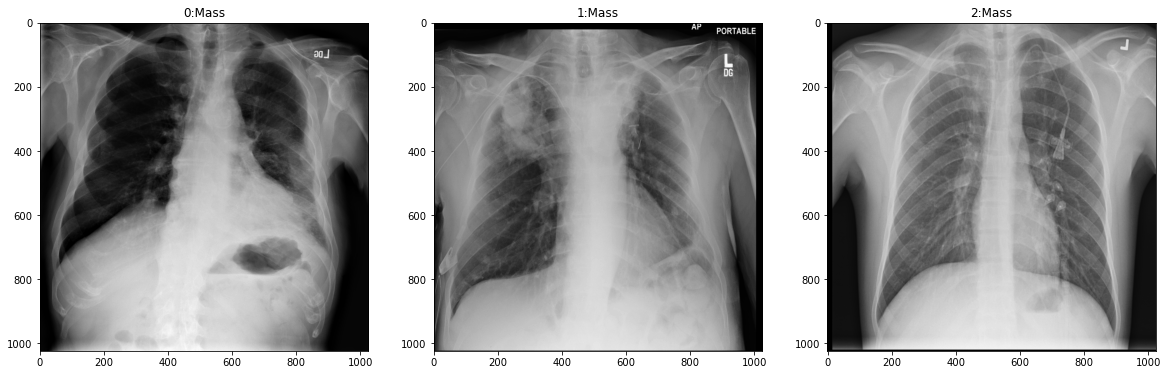

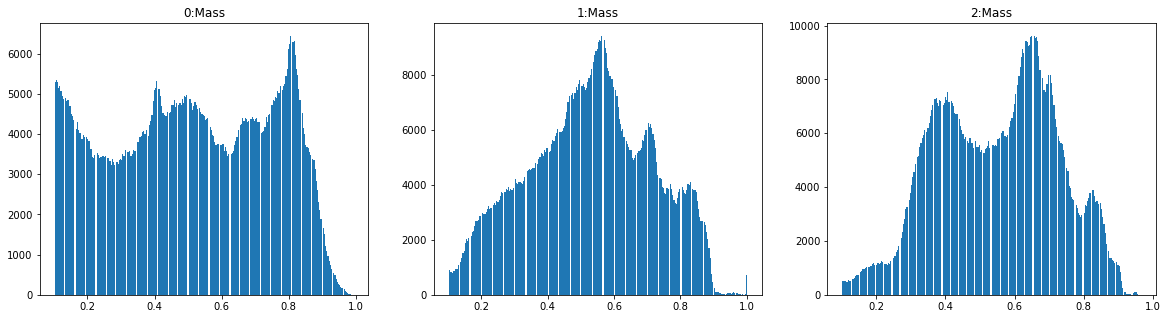

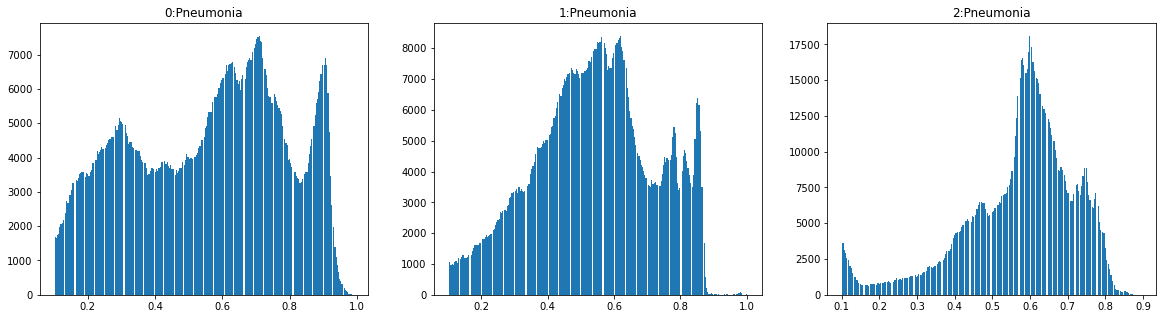

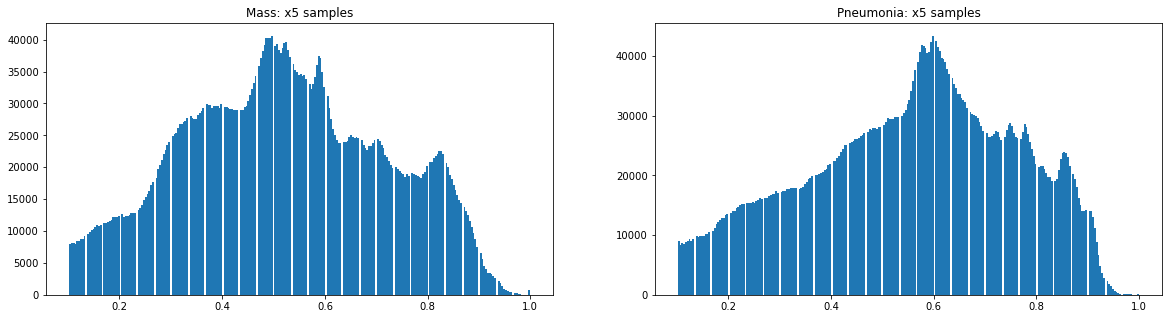

In [84]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Mass')

Mass cases overall seem to have a peak around 0.5.

This contrasts with the sharper peak for Pneumonia cases around 0.6.

#### Intensity distribution of Nodule cases

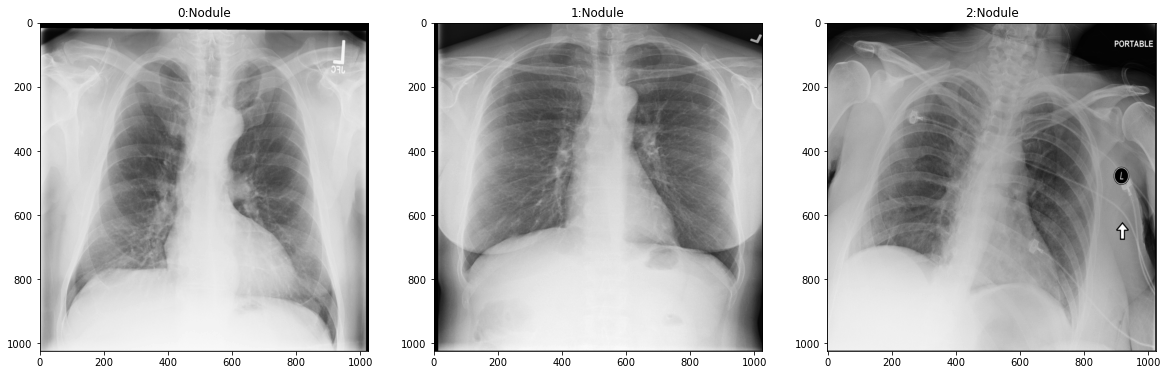

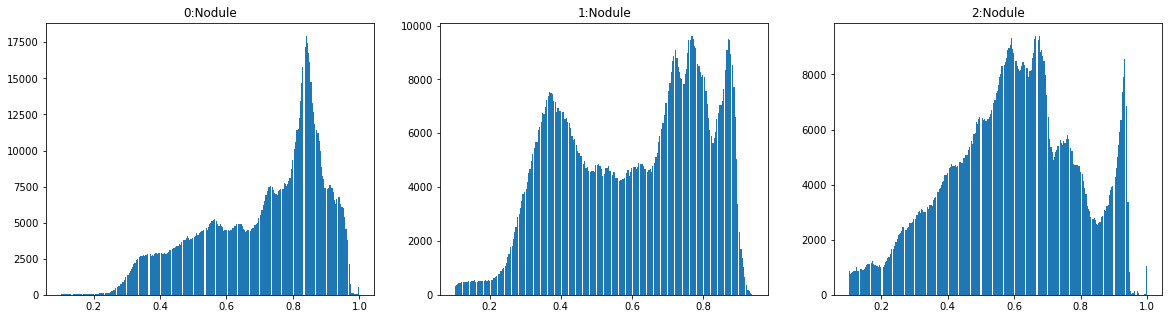

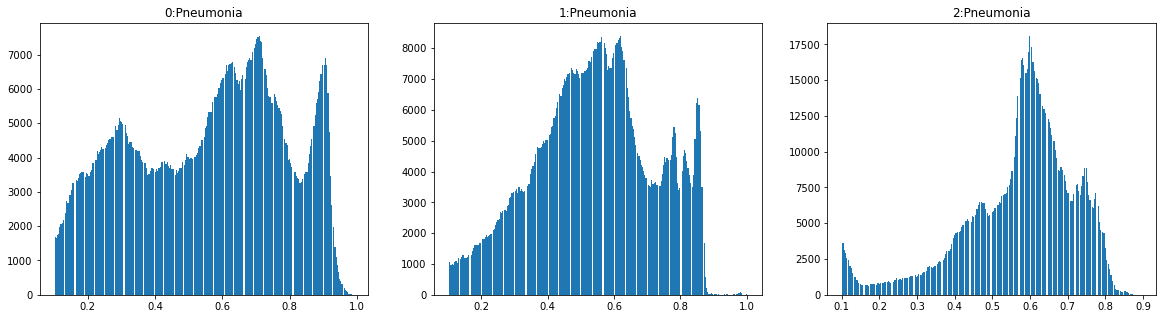

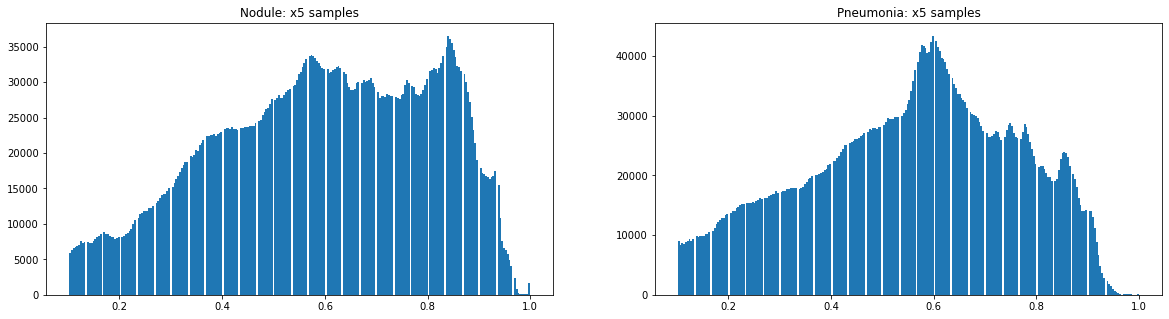

In [85]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Nodule')

For Nodule cases we seem to have a two-peak distribution, one at 0.6 and another at around 0.8.

This contrasts with the single peak at 0.6 of the Pneumonia cases.

#### Intensity distribution of Pleural_Thickening cases

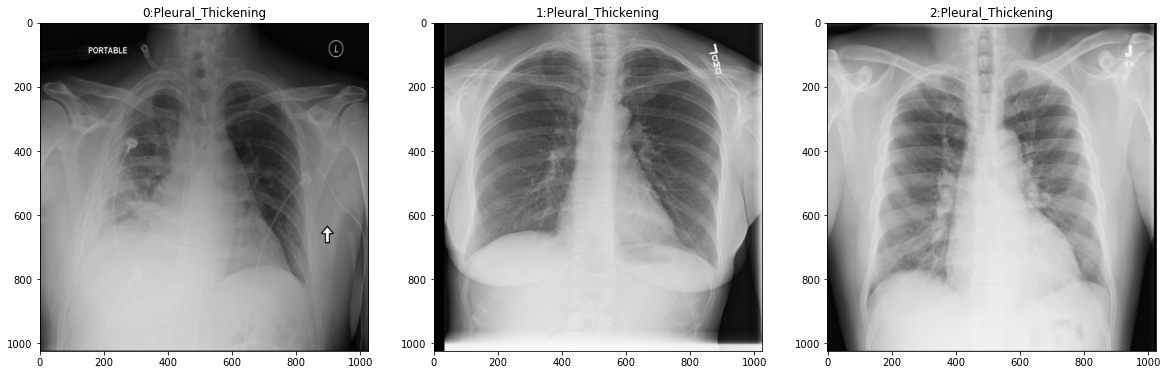

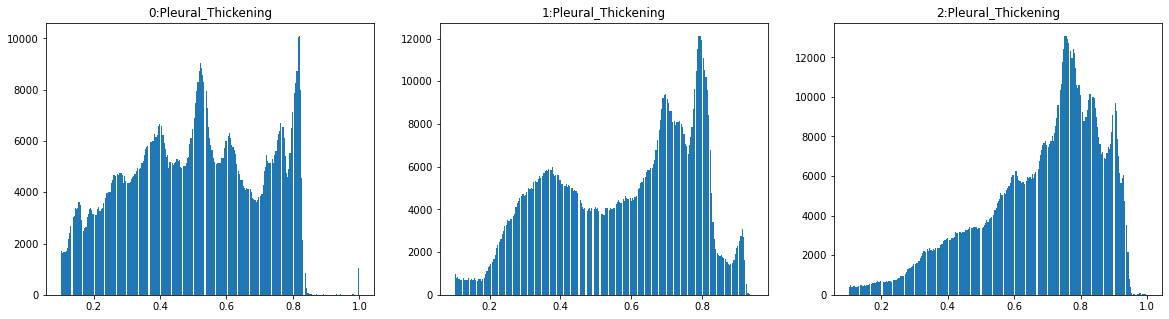

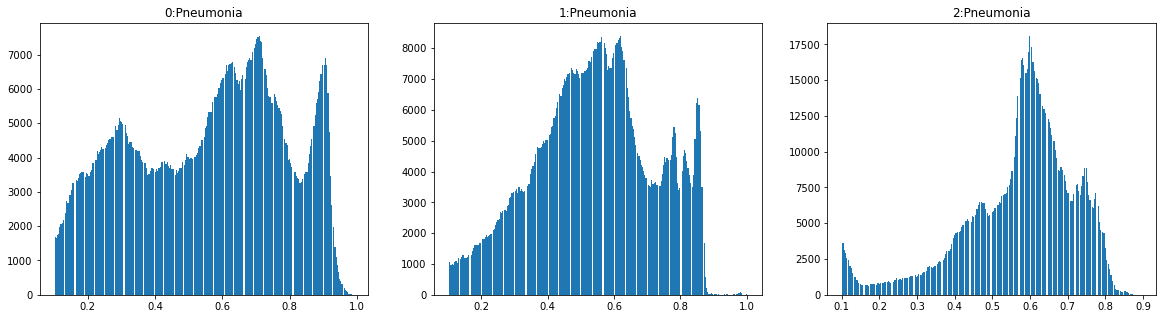

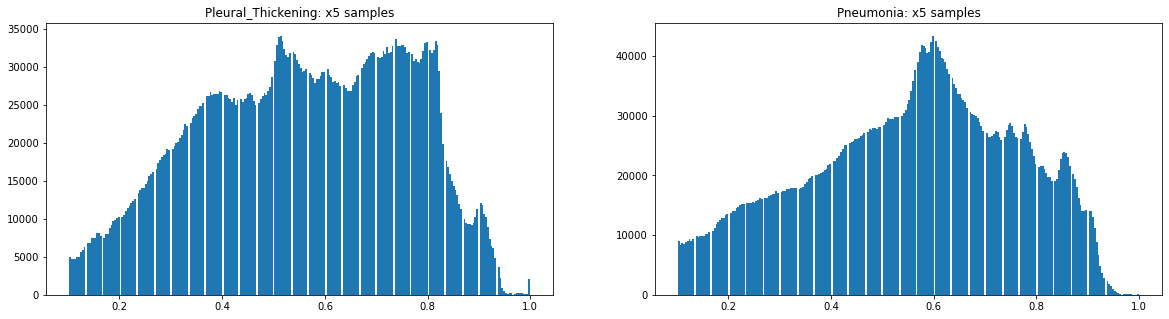

In [86]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Pleural_Thickening')

So for Pleural Thickening cases there seems to be a very broad peak of the distribution overall, between 0.4-0.8, a little higher towards 0.8.

This contrasts the the distinct peak for Pneumonia at 0.6.

#### Intensity distribution of Pneumothorax cases

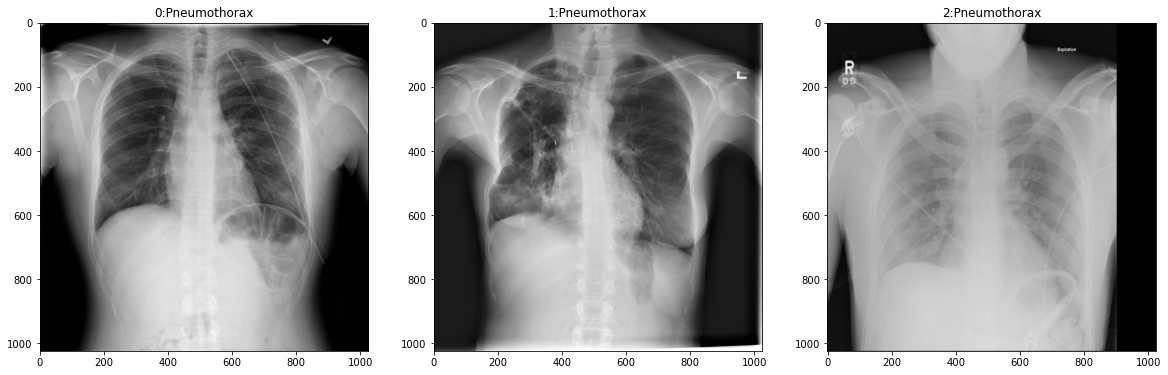

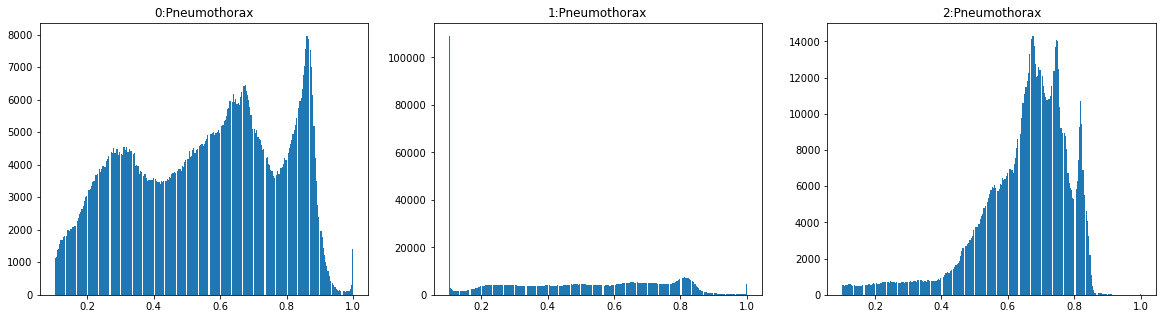

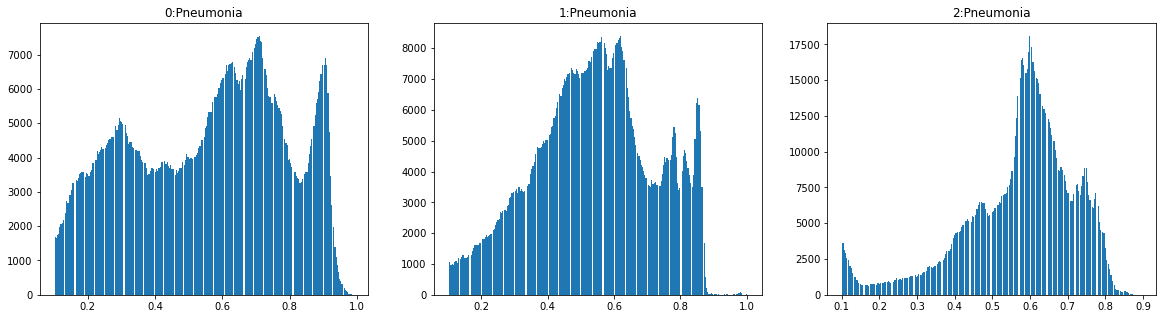

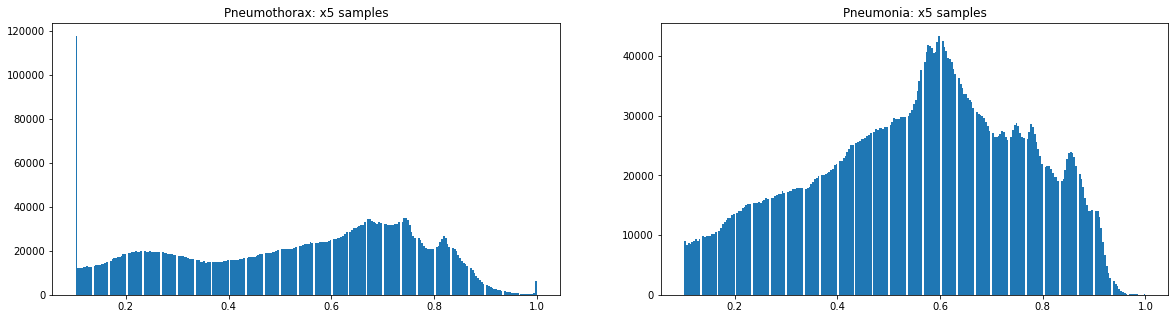

In [87]:
# Show x-rays & intensity distributions for this disease & Pneumonia
image_intensity_selection_display(sample_df, 'Pneumothorax')

Pneumothorax cases seem to have a very flat distribution, with slight peaks at around 0.2 and 0.7.

This contrasts with the distinct peak of the Pneumonia cases at 0.6.

## 3 Conclusions

### 3.1 Patient meta data

Our main objective is to develop a model that can predict Pneumonia. A key finding from our exploration is that our dataset is very unbalanced in terms of Pneumonia vs Non-Pneumonia examples. In particular we have in our dataset:

- Pneumonia cases: 1.2%
- Non-Pneumonia cases: 98.8%

We will need to take this into consideration when building & training our model i.e. for constructing an appropriate class-balanced training dataset, and class realistic validation dataset.

While we also discovered a difference in the distribution of the ages of the Pneumonia cases vs Non-Pneumonia cases (with Pneumonia cases having more examples in the 20-40 years age range than the general population) this is a relatively small difference, so we may or may not take this into consideration when constructing appropriate training & validation datasets.

We also discovered a significant difference in the view distribution between the Pneumonia cases vs Non-Pneumonia cases, so we may well take this into consideration when constructing appropriate training & validation datasets.

### 3.2 Image pixel level assesments

From our explorations of the distributions of intensity values comparing Pneumonia cases vs non-Pneumonia cases, we discovered that certain diseases appeared to have more distinct distributions from Pneumonia, while other diseases had only very subtle differences in their intensity profiles when compared to Pneumonia.

For example we observed that the distribution of intensities for Effusion was very similar to that of Pneumonia with mainly very subtle differences. Wheras the distribution of intensities for Hernia was far more distinct from those of Pneumonia.

There was also much variation of the distribution of values for samples for the same class, despite the application of the Otsu method to remove background pixels. My approach to include aggregate distributions of 5 examples of each class, was helpful for determining what the overall distribution for each disease might be.

These findings suggest that a conventional classification machine learning model that used e.g. a maximum intensity value as a threshold value to determine the class, may not be sufficient to generate predictions with a good level of accuracy accross all cases. This also then suggests that a deep learning approach i.e. using a convolutional model will probably have the best chance to achieve the best accuracy in predictions, especially for the more subtle differences between and within different disease types and Pneumonia cases.

Finally, we also observed the Otsu method for filtering out background pixels prooved very effective at doing this, and for seeing the unique intensity profiles for each disease case more clearly. With this result, we may also want to consider using the same Otsu background filtering we used here as level of image pre-processing for our training data - to give it the best chance of achieving good results for classifying Pneuomia cases correctly.